Imports

In [11]:
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.regression import NormalizedRootMeanSquaredError
import torch
import torch.nn as nn
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from PIL import Image # <-- Adicione esta linha

In [12]:
EPOCHS = 200
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Caminho para o dataset "Doencas-Olhos"
DATA_DIR = 'datasetsTCC/Doencas-Olhos'


class ConvertToHSV_VChannel:

    def __call__(self, pil_image):
        # Converte a imagem para o espaço de cores HSV
        hsv_image = pil_image.convert('HSV')
        _, _, v_channel = hsv_image.split()
        return v_channel


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    ConvertToHSV_VChannel(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        print(f"Classes encontradas: {self.class_to_idx}")
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                files_in_class = glob.glob(os.path.join(class_dir, '**', ext), recursive=True)
                self.image_files.extend(files_in_class)
                self.labels.extend([class_idx] * len(files_in_class))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================================================================
# --- DIVISÃO ESTRATIFICADA E CRIAÇÃO DOS DATALOADERS ---
# ==============================================================================
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform)
if len(full_dataset) > 0:
    dataset_labels = full_dataset.labels
    dataset_indices = list(range(len(full_dataset)))
    train_indices, temp_indices, _, temp_labels = train_test_split(
        dataset_indices, dataset_labels, test_size=0.30, stratify=dataset_labels, random_state=42
    )
    val_indices, test_indices, _, _ = train_test_split(
        temp_indices, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
    )
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    print(f"\nDivisão estratificada concluída:")
    print(f"Conjunto de Treino: {len(train_dataset)} imagens")
    print(f"Conjunto de Validação: {len(val_dataset)} imagens")
    print(f"Conjunto de Teste: {len(test_dataset)} imagens")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("\nDataLoaders de treino, validação e teste criados com sucesso!")
else:
    print("ERRO: O dataset está vazio ou as classes não foram encontradas no formato esperado.")
    train_loader = DataLoader([], batch_size=BATCH_SIZE)
    val_loader = DataLoader([], batch_size=BATCH_SIZE)
    test_loader = DataLoader([], batch_size=BATCH_SIZE)

# --- FUNÇÃO PARA VISUALIZAR IMAGENS (PARA ESCALA DE CINZA) ---
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    num_images_to_plot = min(n, original.size(0))
    for i in range(num_images_to_plot):
        # Imagem original
        ax = plt.subplot(2, num_images_to_plot, i + 1)
        img = original[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2: ax.set_title("Originais")

        # Imagem reconstruída
        ax = plt.subplot(2, num_images_to_plot, i + 1 + num_images_to_plot)
        rec_img = reconstructed[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(rec_img, cmap='gray')
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2: ax.set_title("Reconstruídas")
    plt.show()


Usando dispositivo: cuda
Classes encontradas: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

Divisão estratificada concluída:
Conjunto de Treino: 2951 imagens
Conjunto de Validação: 633 imagens
Conjunto de Teste: 633 imagens

DataLoaders de treino, validação e teste criados com sucesso!


Autoencoder CovalucionalTeste

In [14]:
# --- 1. DEFINIÇÃO DO MODELO MAIS PROFUNDO (5 CAMADAS) ---
class DeeperConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(DeeperConvolutionalAutoencoder, self).__init__()

        # Encoder com 5 camadas para comprimir de 512x512 para 16x16
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 512, 512]
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),       # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),      # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),      # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),     # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),    # -> [N, 256, 16, 16] (Gargalo)
            nn.ReLU(),
        )

        # Decoder com 5 camadas para reconstruir de 16x16 para 512x512
        self.decoder = nn.Sequential(
            # Entrada: [N, 256, 16, 16]
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> [N, 1, 512, 512]
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- 2. TREINAMENTO DO MODELO PROFUNDO COM MÉTRICAS ---
model_deep_vanilla = DeeperConvolutionalAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_deep_vanilla.parameters(), lr=LEARNING_RATE)

# Instanciar os objetos das três métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss = 0
    model_deep_vanilla.train()

    # MUDANÇA: Envolvemos o train_loader com tqdm() para criar a barra de progresso
    # O parâmetro 'desc' adiciona um texto descritivo à barra.
    # O 'leave=False' faz com que a barra desapareça após a conclusão da época, mantendo o log limpo.
    for data in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=False):
        images, _ = data
        images = images.to(DEVICE)

        outputs = model_deep_vanilla(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    # O resto do código permanece o mesmo
    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss/len(train_loader)

    # O print final da época aparecerá após a conclusão da barra de progresso
    print(f"Deep Vanilla AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados no conjunto de teste ---")
model_deep_vanilla.eval()
with torch.no_grad():
    # Usamos o test_loader para a avaliação final
    try:
        data_iter = iter(test_loader)
        test_images, _ = next(data_iter)
        test_images = test_images.to(DEVICE)

        reconstructed_images = model_deep_vanilla(test_images)

        # Usamos os mesmos objetos de métrica (eles foram resetados após o treino)
        psnr_val = psnr_metric(reconstructed_images, test_images)
        ssim_val = ssim_metric(reconstructed_images, test_images)
        nrmse_val = nrmse_metric(reconstructed_images, test_images)

        print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

        # Supondo que a função plot_images() já foi definida anteriormente no seu código
        plot_images(test_images, reconstructed_images)

    except (NameError, StopIteration):
        print("Não foi possível carregar o lote de teste para visualização.")


# --- 4. CONGELAR E SALVAR O ENCODER PROFUNDO TREINADO ---
print("\n--- Congelando e salvando o encoder ---")

trained_encoder = model_deep_vanilla.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_deep_encoder.pth')
print("Encoder profundo congelado e salvo com sucesso em 'frozen_deep_encoder.pth'!")


Deep Vanilla AE | Epoch [1/200], Loss: 0.4011, PSNR: 11.91 dB, SSIM: 0.1943, NRMSE: -3.2594


Deep Vanilla AE | Epoch [2/200], Loss: 0.2442, PSNR: 14.70 dB, SSIM: 0.5002, NRMSE: -2.3649


Deep Vanilla AE | Epoch [3/200], Loss: 0.1790, PSNR: 16.40 dB, SSIM: 0.5274, NRMSE: -1.9454


Deep Vanilla AE | Epoch [4/200], Loss: 0.0780, PSNR: 22.52 dB, SSIM: 0.6173, NRMSE: -0.9615


Deep Vanilla AE | Epoch [5/200], Loss: 0.0508, PSNR: 25.38 dB, SSIM: 0.7610, NRMSE: -0.6917


Deep Vanilla AE | Epoch [6/200], Loss: 0.0433, PSNR: 26.67 dB, SSIM: 0.7973, NRMSE: -0.5958


Deep Vanilla AE | Epoch [7/200], Loss: 0.0368, PSNR: 28.00 dB, SSIM: 0.8309, NRMSE: -0.5114


Deep Vanilla AE | Epoch [8/200], Loss: 0.0343, PSNR: 28.74 dB, SSIM: 0.8465, NRMSE: -0.4698


Deep Vanilla AE | Epoch [9/200], Loss: 0.0341, PSNR: 28.93 dB, SSIM: 0.8531, NRMSE: -0.4597


Deep Vanilla AE | Epoch [10/200], Loss: 0.0345, PSNR: 29.26 dB, SSIM: 0.8536, NRMSE: -0.4424


Deep Vanilla AE | Epoch [11/200], Loss: 0.0296, PSNR: 30.12 dB, SSIM: 0.8670, NRMSE: -0.4005


Deep Vanilla AE | Epoch [12/200], Loss: 0.0289, PSNR: 30.37 dB, SSIM: 0.8701, NRMSE: -0.3892


Deep Vanilla AE | Epoch [13/200], Loss: 0.0282, PSNR: 30.62 dB, SSIM: 0.8732, NRMSE: -0.3781


Deep Vanilla AE | Epoch [14/200], Loss: 0.0268, PSNR: 30.95 dB, SSIM: 0.8775, NRMSE: -0.3643


Deep Vanilla AE | Epoch [15/200], Loss: 0.0282, PSNR: 30.79 dB, SSIM: 0.8756, NRMSE: -0.3711


Deep Vanilla AE | Epoch [16/200], Loss: 0.0260, PSNR: 31.28 dB, SSIM: 0.8809, NRMSE: -0.3505


Deep Vanilla AE | Epoch [17/200], Loss: 0.0262, PSNR: 31.35 dB, SSIM: 0.8816, NRMSE: -0.3479


Deep Vanilla AE | Epoch [18/200], Loss: 0.0257, PSNR: 31.51 dB, SSIM: 0.8829, NRMSE: -0.3414


Deep Vanilla AE | Epoch [19/200], Loss: 0.0259, PSNR: 31.55 dB, SSIM: 0.8829, NRMSE: -0.3400


Deep Vanilla AE | Epoch [20/200], Loss: 0.0253, PSNR: 31.76 dB, SSIM: 0.8856, NRMSE: -0.3316


Deep Vanilla AE | Epoch [21/200], Loss: 0.0261, PSNR: 31.68 dB, SSIM: 0.8842, NRMSE: -0.3349


Deep Vanilla AE | Epoch [22/200], Loss: 0.0248, PSNR: 31.99 dB, SSIM: 0.8877, NRMSE: -0.3231


Deep Vanilla AE | Epoch [23/200], Loss: 0.0246, PSNR: 32.13 dB, SSIM: 0.8888, NRMSE: -0.3179


Deep Vanilla AE | Epoch [24/200], Loss: 0.0241, PSNR: 32.28 dB, SSIM: 0.8903, NRMSE: -0.3126


Deep Vanilla AE | Epoch [25/200], Loss: 0.0243, PSNR: 32.27 dB, SSIM: 0.8900, NRMSE: -0.3127


Deep Vanilla AE | Epoch [26/200], Loss: 0.0239, PSNR: 32.48 dB, SSIM: 0.8921, NRMSE: -0.3055


Deep Vanilla AE | Epoch [27/200], Loss: 0.0241, PSNR: 32.40 dB, SSIM: 0.8921, NRMSE: -0.3082


Deep Vanilla AE | Epoch [28/200], Loss: 0.0232, PSNR: 32.62 dB, SSIM: 0.8939, NRMSE: -0.3005


Deep Vanilla AE | Epoch [29/200], Loss: 0.0232, PSNR: 32.70 dB, SSIM: 0.8942, NRMSE: -0.2977


Deep Vanilla AE | Epoch [30/200], Loss: 0.0230, PSNR: 32.72 dB, SSIM: 0.8946, NRMSE: -0.2969


Deep Vanilla AE | Epoch [31/200], Loss: 0.0235, PSNR: 32.70 dB, SSIM: 0.8940, NRMSE: -0.2978


Deep Vanilla AE | Epoch [32/200], Loss: 0.0234, PSNR: 32.79 dB, SSIM: 0.8951, NRMSE: -0.2948


Deep Vanilla AE | Epoch [33/200], Loss: 0.0225, PSNR: 32.97 dB, SSIM: 0.8964, NRMSE: -0.2886


Deep Vanilla AE | Epoch [34/200], Loss: 0.0250, PSNR: 32.45 dB, SSIM: 0.8902, NRMSE: -0.3065


Deep Vanilla AE | Epoch [35/200], Loss: 0.0218, PSNR: 33.16 dB, SSIM: 0.8981, NRMSE: -0.2824


Deep Vanilla AE | Epoch [36/200], Loss: 0.0221, PSNR: 33.21 dB, SSIM: 0.8989, NRMSE: -0.2809


Deep Vanilla AE | Epoch [37/200], Loss: 0.0217, PSNR: 33.23 dB, SSIM: 0.8992, NRMSE: -0.2801


Deep Vanilla AE | Epoch [38/200], Loss: 0.0251, PSNR: 32.44 dB, SSIM: 0.8910, NRMSE: -0.3069


Deep Vanilla AE | Epoch [39/200], Loss: 0.0235, PSNR: 32.79 dB, SSIM: 0.8956, NRMSE: -0.2946


Deep Vanilla AE | Epoch [40/200], Loss: 0.0217, PSNR: 33.34 dB, SSIM: 0.9007, NRMSE: -0.2765


Deep Vanilla AE | Epoch [41/200], Loss: 0.0216, PSNR: 33.45 dB, SSIM: 0.9008, NRMSE: -0.2730


Deep Vanilla AE | Epoch [42/200], Loss: 0.0234, PSNR: 33.06 dB, SSIM: 0.8964, NRMSE: -0.2856


Deep Vanilla AE | Epoch [43/200], Loss: 0.0227, PSNR: 33.28 dB, SSIM: 0.8953, NRMSE: -0.2786


Deep Vanilla AE | Epoch [44/200], Loss: 0.0355, PSNR: 29.51 dB, SSIM: 0.8578, NRMSE: -0.4300


Deep Vanilla AE | Epoch [45/200], Loss: 0.0302, PSNR: 31.56 dB, SSIM: 0.8784, NRMSE: -0.3394


Deep Vanilla AE | Epoch [46/200], Loss: 0.0284, PSNR: 32.07 dB, SSIM: 0.8845, NRMSE: -0.3202


Deep Vanilla AE | Epoch [47/200], Loss: 0.0271, PSNR: 32.22 dB, SSIM: 0.8871, NRMSE: -0.3147


Deep Vanilla AE | Epoch [48/200], Loss: 0.0228, PSNR: 33.27 dB, SSIM: 0.8988, NRMSE: -0.2789


Deep Vanilla AE | Epoch [49/200], Loss: 0.0215, PSNR: 33.54 dB, SSIM: 0.9018, NRMSE: -0.2703


Deep Vanilla AE | Epoch [50/200], Loss: 0.0217, PSNR: 33.54 dB, SSIM: 0.9015, NRMSE: -0.2702


Deep Vanilla AE | Epoch [51/200], Loss: 0.0204, PSNR: 33.84 dB, SSIM: 0.9046, NRMSE: -0.2612


Deep Vanilla AE | Epoch [52/200], Loss: 0.0202, PSNR: 33.97 dB, SSIM: 0.9059, NRMSE: -0.2571


Deep Vanilla AE | Epoch [53/200], Loss: 0.0198, PSNR: 34.03 dB, SSIM: 0.9065, NRMSE: -0.2554


Deep Vanilla AE | Epoch [54/200], Loss: 0.0197, PSNR: 34.06 dB, SSIM: 0.9067, NRMSE: -0.2546


Deep Vanilla AE | Epoch [55/200], Loss: 0.0229, PSNR: 33.32 dB, SSIM: 0.8992, NRMSE: -0.2773


Deep Vanilla AE | Epoch [56/200], Loss: 0.0213, PSNR: 33.71 dB, SSIM: 0.9033, NRMSE: -0.2650


Deep Vanilla AE | Epoch [57/200], Loss: 0.0207, PSNR: 33.89 dB, SSIM: 0.9054, NRMSE: -0.2598


Deep Vanilla AE | Epoch [58/200], Loss: 0.0204, PSNR: 33.96 dB, SSIM: 0.9061, NRMSE: -0.2576


Deep Vanilla AE | Epoch [59/200], Loss: 0.0202, PSNR: 34.12 dB, SSIM: 0.9072, NRMSE: -0.2528


Deep Vanilla AE | Epoch [60/200], Loss: 0.0204, PSNR: 34.05 dB, SSIM: 0.9062, NRMSE: -0.2549


Deep Vanilla AE | Epoch [61/200], Loss: 0.0197, PSNR: 34.23 dB, SSIM: 0.9081, NRMSE: -0.2496


Deep Vanilla AE | Epoch [62/200], Loss: 0.0196, PSNR: 34.25 dB, SSIM: 0.9082, NRMSE: -0.2492


Deep Vanilla AE | Epoch [63/200], Loss: 0.0196, PSNR: 34.27 dB, SSIM: 0.9087, NRMSE: -0.2485


Deep Vanilla AE | Epoch [64/200], Loss: 0.0196, PSNR: 34.28 dB, SSIM: 0.9085, NRMSE: -0.2483


Deep Vanilla AE | Epoch [65/200], Loss: 0.0197, PSNR: 34.29 dB, SSIM: 0.9085, NRMSE: -0.2481


Deep Vanilla AE | Epoch [66/200], Loss: 0.0194, PSNR: 34.37 dB, SSIM: 0.9091, NRMSE: -0.2456


Deep Vanilla AE | Epoch [67/200], Loss: 0.0197, PSNR: 34.32 dB, SSIM: 0.9089, NRMSE: -0.2472


Deep Vanilla AE | Epoch [68/200], Loss: 0.0300, PSNR: 31.28 dB, SSIM: 0.8832, NRMSE: -0.3505


Deep Vanilla AE | Epoch [69/200], Loss: 0.0283, PSNR: 31.90 dB, SSIM: 0.8877, NRMSE: -0.3263


Deep Vanilla AE | Epoch [70/200], Loss: 0.0266, PSNR: 32.68 dB, SSIM: 0.8920, NRMSE: -0.2985


Deep Vanilla AE | Epoch [71/200], Loss: 0.0250, PSNR: 33.02 dB, SSIM: 0.8958, NRMSE: -0.2871


Deep Vanilla AE | Epoch [72/200], Loss: 0.0233, PSNR: 33.42 dB, SSIM: 0.8996, NRMSE: -0.2741


Deep Vanilla AE | Epoch [73/200], Loss: 0.0195, PSNR: 34.36 dB, SSIM: 0.9093, NRMSE: -0.2459


Deep Vanilla AE | Epoch [74/200], Loss: 0.0197, PSNR: 34.40 dB, SSIM: 0.9095, NRMSE: -0.2448


Deep Vanilla AE | Epoch [75/200], Loss: 0.0189, PSNR: 34.60 dB, SSIM: 0.9112, NRMSE: -0.2392


Deep Vanilla AE | Epoch [76/200], Loss: 0.0189, PSNR: 34.64 dB, SSIM: 0.9113, NRMSE: -0.2382


Deep Vanilla AE | Epoch [77/200], Loss: 0.0190, PSNR: 34.64 dB, SSIM: 0.9114, NRMSE: -0.2381


Deep Vanilla AE | Epoch [78/200], Loss: 0.0186, PSNR: 34.70 dB, SSIM: 0.9119, NRMSE: -0.2366


Deep Vanilla AE | Epoch [79/200], Loss: 0.0188, PSNR: 34.74 dB, SSIM: 0.9123, NRMSE: -0.2353


Deep Vanilla AE | Epoch [80/200], Loss: 0.0188, PSNR: 34.69 dB, SSIM: 0.9117, NRMSE: -0.2369


Deep Vanilla AE | Epoch [81/200], Loss: 0.0185, PSNR: 34.76 dB, SSIM: 0.9128, NRMSE: -0.2348


Deep Vanilla AE | Epoch [82/200], Loss: 0.0196, PSNR: 34.50 dB, SSIM: 0.9108, NRMSE: -0.2419


Deep Vanilla AE | Epoch [83/200], Loss: 0.0185, PSNR: 34.80 dB, SSIM: 0.9128, NRMSE: -0.2337


Deep Vanilla AE | Epoch [84/200], Loss: 0.0185, PSNR: 34.87 dB, SSIM: 0.9134, NRMSE: -0.2318


Deep Vanilla AE | Epoch [85/200], Loss: 0.0189, PSNR: 34.80 dB, SSIM: 0.9129, NRMSE: -0.2338


Deep Vanilla AE | Epoch [86/200], Loss: 0.0188, PSNR: 34.73 dB, SSIM: 0.9131, NRMSE: -0.2356


Deep Vanilla AE | Epoch [87/200], Loss: 0.0193, PSNR: 34.65 dB, SSIM: 0.9116, NRMSE: -0.2380


Deep Vanilla AE | Epoch [88/200], Loss: 0.0188, PSNR: 34.83 dB, SSIM: 0.9129, NRMSE: -0.2330


Deep Vanilla AE | Epoch [89/200], Loss: 0.0198, PSNR: 34.50 dB, SSIM: 0.9102, NRMSE: -0.2421


Deep Vanilla AE | Epoch [90/200], Loss: 0.0190, PSNR: 34.58 dB, SSIM: 0.9124, NRMSE: -0.2397


Deep Vanilla AE | Epoch [91/200], Loss: 0.0200, PSNR: 34.51 dB, SSIM: 0.9106, NRMSE: -0.2417


Deep Vanilla AE | Epoch [92/200], Loss: 0.0208, PSNR: 34.32 dB, SSIM: 0.9093, NRMSE: -0.2470


Deep Vanilla AE | Epoch [93/200], Loss: 0.0204, PSNR: 34.46 dB, SSIM: 0.9078, NRMSE: -0.2431


Deep Vanilla AE | Epoch [94/200], Loss: 0.0194, PSNR: 34.76 dB, SSIM: 0.9087, NRMSE: -0.2349


Deep Vanilla AE | Epoch [95/200], Loss: 0.0192, PSNR: 34.79 dB, SSIM: 0.9091, NRMSE: -0.2341


Deep Vanilla AE | Epoch [96/200], Loss: 0.0203, PSNR: 34.36 dB, SSIM: 0.9060, NRMSE: -0.2459


Deep Vanilla AE | Epoch [97/200], Loss: 0.0182, PSNR: 34.99 dB, SSIM: 0.9143, NRMSE: -0.2288


Deep Vanilla AE | Epoch [98/200], Loss: 0.0184, PSNR: 35.04 dB, SSIM: 0.9145, NRMSE: -0.2275


Deep Vanilla AE | Epoch [99/200], Loss: 0.0183, PSNR: 34.91 dB, SSIM: 0.9148, NRMSE: -0.2308


Deep Vanilla AE | Epoch [100/200], Loss: 0.0187, PSNR: 34.85 dB, SSIM: 0.9146, NRMSE: -0.2325


Deep Vanilla AE | Epoch [101/200], Loss: 0.0177, PSNR: 35.20 dB, SSIM: 0.9169, NRMSE: -0.2232


Deep Vanilla AE | Epoch [102/200], Loss: 0.0185, PSNR: 35.10 dB, SSIM: 0.9158, NRMSE: -0.2259


Deep Vanilla AE | Epoch [103/200], Loss: 0.0181, PSNR: 35.13 dB, SSIM: 0.9164, NRMSE: -0.2251


Deep Vanilla AE | Epoch [104/200], Loss: 0.0179, PSNR: 35.14 dB, SSIM: 0.9167, NRMSE: -0.2248


Deep Vanilla AE | Epoch [105/200], Loss: 0.0178, PSNR: 35.25 dB, SSIM: 0.9170, NRMSE: -0.2219


Deep Vanilla AE | Epoch [106/200], Loss: 0.0178, PSNR: 35.33 dB, SSIM: 0.9175, NRMSE: -0.2199


Deep Vanilla AE | Epoch [107/200], Loss: 0.0182, PSNR: 35.07 dB, SSIM: 0.9167, NRMSE: -0.2266


Deep Vanilla AE | Epoch [108/200], Loss: 0.0179, PSNR: 35.30 dB, SSIM: 0.9175, NRMSE: -0.2206


Deep Vanilla AE | Epoch [109/200], Loss: 0.0185, PSNR: 35.15 dB, SSIM: 0.9164, NRMSE: -0.2245


Deep Vanilla AE | Epoch [110/200], Loss: 0.0176, PSNR: 35.36 dB, SSIM: 0.9180, NRMSE: -0.2191


Deep Vanilla AE | Epoch [111/200], Loss: 0.0175, PSNR: 35.40 dB, SSIM: 0.9183, NRMSE: -0.2181


Deep Vanilla AE | Epoch [112/200], Loss: 0.0177, PSNR: 35.39 dB, SSIM: 0.9180, NRMSE: -0.2183


Deep Vanilla AE | Epoch [113/200], Loss: 0.0178, PSNR: 35.37 dB, SSIM: 0.9178, NRMSE: -0.2190


Deep Vanilla AE | Epoch [114/200], Loss: 0.0180, PSNR: 35.29 dB, SSIM: 0.9178, NRMSE: -0.2211


Deep Vanilla AE | Epoch [115/200], Loss: 0.0184, PSNR: 35.19 dB, SSIM: 0.9172, NRMSE: -0.2234


Deep Vanilla AE | Epoch [116/200], Loss: 0.0175, PSNR: 35.54 dB, SSIM: 0.9193, NRMSE: -0.2148


Deep Vanilla AE | Epoch [117/200], Loss: 0.0196, PSNR: 33.90 dB, SSIM: 0.9124, NRMSE: -0.2593


Deep Vanilla AE | Epoch [118/200], Loss: 0.0183, PSNR: 35.18 dB, SSIM: 0.9177, NRMSE: -0.2237


Deep Vanilla AE | Epoch [119/200], Loss: 0.0177, PSNR: 35.39 dB, SSIM: 0.9187, NRMSE: -0.2185


Deep Vanilla AE | Epoch [120/200], Loss: 0.0176, PSNR: 35.45 dB, SSIM: 0.9188, NRMSE: -0.2169


Deep Vanilla AE | Epoch [121/200], Loss: 0.0183, PSNR: 34.91 dB, SSIM: 0.9175, NRMSE: -0.2309


Deep Vanilla AE | Epoch [122/200], Loss: 0.0178, PSNR: 35.41 dB, SSIM: 0.9188, NRMSE: -0.2180


Deep Vanilla AE | Epoch [123/200], Loss: 0.0174, PSNR: 35.57 dB, SSIM: 0.9202, NRMSE: -0.2140


Deep Vanilla AE | Epoch [124/200], Loss: 0.0172, PSNR: 35.63 dB, SSIM: 0.9206, NRMSE: -0.2125


Deep Vanilla AE | Epoch [125/200], Loss: 0.0238, PSNR: 33.73 dB, SSIM: 0.9056, NRMSE: -0.2644


Deep Vanilla AE | Epoch [126/200], Loss: 0.0261, PSNR: 33.12 dB, SSIM: 0.8990, NRMSE: -0.2836


Deep Vanilla AE | Epoch [127/200], Loss: 0.0243, PSNR: 33.67 dB, SSIM: 0.9032, NRMSE: -0.2664


Deep Vanilla AE | Epoch [128/200], Loss: 0.0247, PSNR: 33.32 dB, SSIM: 0.9037, NRMSE: -0.2773


Deep Vanilla AE | Epoch [129/200], Loss: 0.0226, PSNR: 34.11 dB, SSIM: 0.9071, NRMSE: -0.2532


Deep Vanilla AE | Epoch [130/200], Loss: 0.0222, PSNR: 34.30 dB, SSIM: 0.9090, NRMSE: -0.2478


Deep Vanilla AE | Epoch [131/200], Loss: 0.0221, PSNR: 34.38 dB, SSIM: 0.9094, NRMSE: -0.2454


Deep Vanilla AE | Epoch [132/200], Loss: 0.0208, PSNR: 34.66 dB, SSIM: 0.9119, NRMSE: -0.2376


Deep Vanilla AE | Epoch [133/200], Loss: 0.0208, PSNR: 34.68 dB, SSIM: 0.9122, NRMSE: -0.2370


Deep Vanilla AE | Epoch [134/200], Loss: 0.0182, PSNR: 35.35 dB, SSIM: 0.9176, NRMSE: -0.2193


Deep Vanilla AE | Epoch [135/200], Loss: 0.0174, PSNR: 35.65 dB, SSIM: 0.9201, NRMSE: -0.2120


Deep Vanilla AE | Epoch [136/200], Loss: 0.0175, PSNR: 35.61 dB, SSIM: 0.9199, NRMSE: -0.2130


Deep Vanilla AE | Epoch [137/200], Loss: 0.0164, PSNR: 35.90 dB, SSIM: 0.9221, NRMSE: -0.2059


Deep Vanilla AE | Epoch [138/200], Loss: 0.0161, PSNR: 36.07 dB, SSIM: 0.9233, NRMSE: -0.2021


Deep Vanilla AE | Epoch [139/200], Loss: 0.0160, PSNR: 36.01 dB, SSIM: 0.9232, NRMSE: -0.2034


Deep Vanilla AE | Epoch [140/200], Loss: 0.0164, PSNR: 35.98 dB, SSIM: 0.9230, NRMSE: -0.2041


Deep Vanilla AE | Epoch [141/200], Loss: 0.0161, PSNR: 36.05 dB, SSIM: 0.9234, NRMSE: -0.2024


Deep Vanilla AE | Epoch [142/200], Loss: 0.0160, PSNR: 36.10 dB, SSIM: 0.9238, NRMSE: -0.2012


Deep Vanilla AE | Epoch [143/200], Loss: 0.0172, PSNR: 35.79 dB, SSIM: 0.9218, NRMSE: -0.2086


Deep Vanilla AE | Epoch [144/200], Loss: 0.0166, PSNR: 35.95 dB, SSIM: 0.9229, NRMSE: -0.2049


Deep Vanilla AE | Epoch [145/200], Loss: 0.0160, PSNR: 36.12 dB, SSIM: 0.9240, NRMSE: -0.2007


Deep Vanilla AE | Epoch [146/200], Loss: 0.0163, PSNR: 36.13 dB, SSIM: 0.9239, NRMSE: -0.2006


Deep Vanilla AE | Epoch [147/200], Loss: 0.0160, PSNR: 36.19 dB, SSIM: 0.9244, NRMSE: -0.1992


Deep Vanilla AE | Epoch [148/200], Loss: 0.0161, PSNR: 36.17 dB, SSIM: 0.9243, NRMSE: -0.1997


Deep Vanilla AE | Epoch [149/200], Loss: 0.0164, PSNR: 36.02 dB, SSIM: 0.9239, NRMSE: -0.2032


Deep Vanilla AE | Epoch [150/200], Loss: 0.0164, PSNR: 35.95 dB, SSIM: 0.9236, NRMSE: -0.2048


Deep Vanilla AE | Epoch [151/200], Loss: 0.0166, PSNR: 36.03 dB, SSIM: 0.9237, NRMSE: -0.2029


Deep Vanilla AE | Epoch [152/200], Loss: 0.0162, PSNR: 36.19 dB, SSIM: 0.9248, NRMSE: -0.1991


Deep Vanilla AE | Epoch [153/200], Loss: 0.0161, PSNR: 36.18 dB, SSIM: 0.9247, NRMSE: -0.1995


Deep Vanilla AE | Epoch [154/200], Loss: 0.0161, PSNR: 36.17 dB, SSIM: 0.9248, NRMSE: -0.1997


Deep Vanilla AE | Epoch [155/200], Loss: 0.0163, PSNR: 36.15 dB, SSIM: 0.9244, NRMSE: -0.2002


Deep Vanilla AE | Epoch [156/200], Loss: 0.0164, PSNR: 36.04 dB, SSIM: 0.9246, NRMSE: -0.2028


Deep Vanilla AE | Epoch [157/200], Loss: 0.0181, PSNR: 35.56 dB, SSIM: 0.9209, NRMSE: -0.2142


Deep Vanilla AE | Epoch [158/200], Loss: 0.0166, PSNR: 35.97 dB, SSIM: 0.9236, NRMSE: -0.2044


Deep Vanilla AE | Epoch [159/200], Loss: 0.0173, PSNR: 35.96 dB, SSIM: 0.9237, NRMSE: -0.2046


Deep Vanilla AE | Epoch [160/200], Loss: 0.0236, PSNR: 32.98 dB, SSIM: 0.9054, NRMSE: -0.2883


Deep Vanilla AE | Epoch [161/200], Loss: 0.0234, PSNR: 33.58 dB, SSIM: 0.9057, NRMSE: -0.2689


Deep Vanilla AE | Epoch [162/200], Loss: 0.0230, PSNR: 34.18 dB, SSIM: 0.9095, NRMSE: -0.2512


Deep Vanilla AE | Epoch [163/200], Loss: 0.0211, PSNR: 34.66 dB, SSIM: 0.9139, NRMSE: -0.2375


Deep Vanilla AE | Epoch [164/200], Loss: 0.0215, PSNR: 34.64 dB, SSIM: 0.9132, NRMSE: -0.2382


Deep Vanilla AE | Epoch [165/200], Loss: 0.0204, PSNR: 34.78 dB, SSIM: 0.9152, NRMSE: -0.2344


Deep Vanilla AE | Epoch [166/200], Loss: 0.0205, PSNR: 34.96 dB, SSIM: 0.9161, NRMSE: -0.2296


Deep Vanilla AE | Epoch [167/200], Loss: 0.0205, PSNR: 34.93 dB, SSIM: 0.9169, NRMSE: -0.2302


Deep Vanilla AE | Epoch [168/200], Loss: 0.0200, PSNR: 35.16 dB, SSIM: 0.9175, NRMSE: -0.2244


Deep Vanilla AE | Epoch [169/200], Loss: 0.0199, PSNR: 35.16 dB, SSIM: 0.9175, NRMSE: -0.2243


Deep Vanilla AE | Epoch [170/200], Loss: 0.0191, PSNR: 35.50 dB, SSIM: 0.9199, NRMSE: -0.2157


Deep Vanilla AE | Epoch [171/200], Loss: 0.0180, PSNR: 35.66 dB, SSIM: 0.9215, NRMSE: -0.2116


Deep Vanilla AE | Epoch [172/200], Loss: 0.0162, PSNR: 36.15 dB, SSIM: 0.9254, NRMSE: -0.2001


Deep Vanilla AE | Epoch [173/200], Loss: 0.0158, PSNR: 36.34 dB, SSIM: 0.9263, NRMSE: -0.1958


Deep Vanilla AE | Epoch [174/200], Loss: 0.0153, PSNR: 36.51 dB, SSIM: 0.9272, NRMSE: -0.1920


Deep Vanilla AE | Epoch [175/200], Loss: 0.0154, PSNR: 36.55 dB, SSIM: 0.9276, NRMSE: -0.1911


Deep Vanilla AE | Epoch [176/200], Loss: 0.0151, PSNR: 36.61 dB, SSIM: 0.9280, NRMSE: -0.1899


Deep Vanilla AE | Epoch [177/200], Loss: 0.0152, PSNR: 36.59 dB, SSIM: 0.9279, NRMSE: -0.1903


Deep Vanilla AE | Epoch [178/200], Loss: 0.0155, PSNR: 36.50 dB, SSIM: 0.9274, NRMSE: -0.1922


Deep Vanilla AE | Epoch [179/200], Loss: 0.0156, PSNR: 36.51 dB, SSIM: 0.9275, NRMSE: -0.1920


Deep Vanilla AE | Epoch [180/200], Loss: 0.0154, PSNR: 36.62 dB, SSIM: 0.9282, NRMSE: -0.1895


Deep Vanilla AE | Epoch [181/200], Loss: 0.0150, PSNR: 36.65 dB, SSIM: 0.9281, NRMSE: -0.1890


Deep Vanilla AE | Epoch [182/200], Loss: 0.0153, PSNR: 36.65 dB, SSIM: 0.9285, NRMSE: -0.1890


Deep Vanilla AE | Epoch [183/200], Loss: 0.0154, PSNR: 36.59 dB, SSIM: 0.9283, NRMSE: -0.1902


Deep Vanilla AE | Epoch [184/200], Loss: 0.0151, PSNR: 36.63 dB, SSIM: 0.9284, NRMSE: -0.1894


Deep Vanilla AE | Epoch [185/200], Loss: 0.0160, PSNR: 36.45 dB, SSIM: 0.9275, NRMSE: -0.1934


Deep Vanilla AE | Epoch [186/200], Loss: 0.0152, PSNR: 36.64 dB, SSIM: 0.9286, NRMSE: -0.1892


Deep Vanilla AE | Epoch [187/200], Loss: 0.0151, PSNR: 36.66 dB, SSIM: 0.9289, NRMSE: -0.1888


Deep Vanilla AE | Epoch [188/200], Loss: 0.0150, PSNR: 36.65 dB, SSIM: 0.9288, NRMSE: -0.1890


Deep Vanilla AE | Epoch [189/200], Loss: 0.0157, PSNR: 36.34 dB, SSIM: 0.9278, NRMSE: -0.1958


Deep Vanilla AE | Epoch [190/200], Loss: 0.0165, PSNR: 35.72 dB, SSIM: 0.9261, NRMSE: -0.2102


Deep Vanilla AE | Epoch [191/200], Loss: 0.0156, PSNR: 36.41 dB, SSIM: 0.9284, NRMSE: -0.1943


Deep Vanilla AE | Epoch [192/200], Loss: 0.0155, PSNR: 36.54 dB, SSIM: 0.9285, NRMSE: -0.1913


Deep Vanilla AE | Epoch [193/200], Loss: 0.0178, PSNR: 35.72 dB, SSIM: 0.9232, NRMSE: -0.2102


Deep Vanilla AE | Epoch [194/200], Loss: 0.0170, PSNR: 35.95 dB, SSIM: 0.9231, NRMSE: -0.2048


Deep Vanilla AE | Epoch [195/200], Loss: 0.0177, PSNR: 35.84 dB, SSIM: 0.9181, NRMSE: -0.2074


Deep Vanilla AE | Epoch [196/200], Loss: 0.0160, PSNR: 36.39 dB, SSIM: 0.9264, NRMSE: -0.1946


Deep Vanilla AE | Epoch [197/200], Loss: 0.0154, PSNR: 36.68 dB, SSIM: 0.9291, NRMSE: -0.1884


Deep Vanilla AE | Epoch [198/200], Loss: 0.0152, PSNR: 36.72 dB, SSIM: 0.9296, NRMSE: -0.1875


Deep Vanilla AE | Epoch [199/200], Loss: 0.0174, PSNR: 35.22 dB, SSIM: 0.9244, NRMSE: -0.2227


Deep Vanilla AE | Epoch [200/200], Loss: 0.0156, PSNR: 36.41 dB, SSIM: 0.9286, NRMSE: -0.1942


Autoencoder Esparso

Deep Sparse AE | Epoch [1/200], Loss: 0.4971, Recon: 0.3831, Sparsity: 126.6806, PSNR: 12.74 dB, SSIM: 0.3501, NRMSE: -1.2157
Deep Sparse AE | Epoch [2/200], Loss: 0.4877, Recon: 0.3737, Sparsity: 126.6258, PSNR: 12.80 dB, SSIM: 0.4126, NRMSE: -1.2076
Deep Sparse AE | Epoch [3/200], Loss: 0.4910, Recon: 0.3770, Sparsity: 126.6258, PSNR: 12.80 dB, SSIM: 0.4158, NRMSE: -1.2066
Deep Sparse AE | Epoch [4/200], Loss: 0.4964, Recon: 0.3825, Sparsity: 126.6258, PSNR: 12.82 dB, SSIM: 0.4127, NRMSE: -1.2043
Deep Sparse AE | Epoch [5/200], Loss: 0.4859, Recon: 0.3720, Sparsity: 126.6258, PSNR: 12.94 dB, SSIM: 0.3810, NRMSE: -1.1877
Deep Sparse AE | Epoch [6/200], Loss: 0.4703, Recon: 0.3564, Sparsity: 126.6258, PSNR: 12.98 dB, SSIM: 0.3743, NRMSE: -1.1821
Deep Sparse AE | Epoch [7/200], Loss: 0.4729, Recon: 0.3589, Sparsity: 126.6258, PSNR: 12.97 dB, SSIM: 0.3917, NRMSE: -1.1837
Deep Sparse AE | Epoch [8/200], Loss: 0.4727, Recon: 0.3588, Sparsity: 126.6258, PSNR: 12.97 dB, SSIM: 0.3976, NRMSE: 

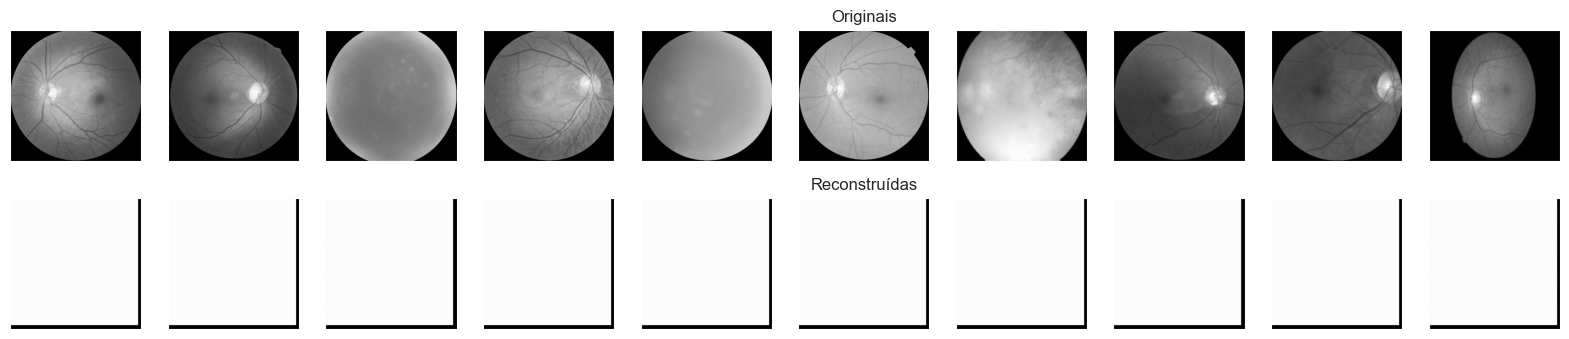


--- Congelando e salvando o encoder ---
Encoder Esparso Profundo congelado e salvo com sucesso em 'frozen_deep_sparse_encoder.pth'!

--- Exemplo de como carregar o encoder esparso profundo ---
Os parâmetros do encoder carregado estão congelados? False


In [11]:
# Lembre-se de incluir as outras importações necessárias (Subset, sklearn, etc.) se for usar a divisão estratificada.

# Supondo que suas configurações (EPOCHS, LEARNING_RATE, etc.) e os DataLoaders já estejam definidos.
# --- 1. FUNÇÃO AUXILIAR PARA A PENALIDADE DE ESPARSIDADE (sem alterações) ---
def kl_divergence_sparsity(rho, rho_hat):
    activations = torch.sigmoid(rho_hat)
    avg_activations = activations.mean(dim=(0, 2, 3))
    avg_activations = torch.clamp(avg_activations, 1e-6, 1 - 1e-6)
    kl_div = rho * torch.log(rho / avg_activations) + (1 - rho) * torch.log((1 - rho) / (1 - avg_activations))
    return torch.sum(kl_div)

# --- 2. DEFINIÇÃO DO MODELO ESPARSO PROFUNDO ---
class DeepSparseAutoencoder(nn.Module):
    def __init__(self):
        super(DeepSparseAutoencoder, self).__init__()
        # Encoder com 5 camadas para comprimir de 512x512 para 16x16
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 512, 512]
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),       # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),      # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),      # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),     # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),    # -> [N, 256, 16, 16] (Camada Oculta)
            nn.ReLU(),
        )
        # Decoder com 5 camadas para reconstruir de 16x16 para 512x512
        self.decoder = nn.Sequential(
            # Entrada: [N, 256, 16, 16]
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)
    def forward(self, x): return self.decode(self.encode(x))

# --- 3. TREINAMENTO DO MODELO ESPARSO PROFUNDO COM MÉTRICAS ---
SPARSITY_TARGET = 0.05
SPARSITY_WEIGHT = 0.0009

model_deep_sparse = DeepSparseAutoencoder().to(DEVICE) # MUDANÇA: Instancia o novo modelo
criterion = nn.L1Loss()
optimizer = optim.Adam(model_deep_sparse.parameters(), lr=LEARNING_RATE)

# Instanciar os objetos das métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss, total_recon_loss, total_sparsity_loss = 0, 0, 0
    model_deep_sparse.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        encoded_activations = model_deep_sparse.encode(images)
        outputs = model_deep_sparse.decode(encoded_activations)

        recon_loss = criterion(outputs, images)
        sparsity_loss = kl_divergence_sparsity(SPARSITY_TARGET, encoded_activations)
        loss = recon_loss + SPARSITY_WEIGHT * sparsity_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_sparsity_loss += sparsity_loss.item()

        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon_loss / len(train_loader)
    avg_sparsity = total_sparsity_loss / len(train_loader)

    print(f"Deep Sparse AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, Sparsity: {avg_sparsity:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 4. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados do Sparse Autoencoder Profundo ---")
model_deep_sparse.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)
    reconstructed_images = model_deep_sparse(test_images)

    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 5. CONGELAR E SALVAR O ENCODER TREINADO ---
print("\n--- Congelando e salvando o encoder ---")
trained_encoder = model_deep_sparse.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_deep_sparse_encoder.pth')
print("Encoder Esparso Profundo congelado e salvo com sucesso em 'frozen_deep_sparse_encoder.pth'!")

# --- 6. (BÔNUS) Exemplo de Como Carregar e Usar o Encoder Depois ---
print("\n--- Exemplo de como carregar o encoder esparso profundo ---")
# MUDANÇA: A arquitetura a ser definida deve ser a profunda de 5 camadas
encoder_architecture = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
)

loaded_encoder = encoder_architecture
loaded_encoder.load_state_dict(torch.load('frozen_deep_sparse_encoder.pth'))
loaded_encoder.to(DEVICE)
loaded_encoder.eval()
is_frozen = all(not param.requires_grad for param in loaded_encoder.parameters())
print(f"Os parâmetros do encoder carregado estão congelados? {is_frozen}")

Denoising AutoEncoder

Deep Denoising AE | Epoch [1/200], Loss: 0.3761, PSNR: 11.93 dB, SSIM: 0.0115, NRMSE: -1.3339
Deep Denoising AE | Epoch [2/200], Loss: 0.1531, PSNR: 18.60 dB, SSIM: 0.3823, NRMSE: -0.6190
Deep Denoising AE | Epoch [3/200], Loss: 0.0977, PSNR: 20.87 dB, SSIM: 0.6642, NRMSE: -0.4767
Deep Denoising AE | Epoch [4/200], Loss: 0.0669, PSNR: 23.46 dB, SSIM: 0.7232, NRMSE: -0.3536
Deep Denoising AE | Epoch [5/200], Loss: 0.0491, PSNR: 25.91 dB, SSIM: 0.7649, NRMSE: -0.2668
Deep Denoising AE | Epoch [6/200], Loss: 0.0405, PSNR: 27.51 dB, SSIM: 0.8238, NRMSE: -0.2220
Deep Denoising AE | Epoch [7/200], Loss: 0.0352, PSNR: 28.45 dB, SSIM: 0.8478, NRMSE: -0.1991
Deep Denoising AE | Epoch [8/200], Loss: 0.0327, PSNR: 29.05 dB, SSIM: 0.8571, NRMSE: -0.1859
Deep Denoising AE | Epoch [9/200], Loss: 0.0321, PSNR: 29.37 dB, SSIM: 0.8609, NRMSE: -0.1792
Deep Denoising AE | Epoch [10/200], Loss: 0.0307, PSNR: 29.69 dB, SSIM: 0.8652, NRMSE: -0.1726
Deep Denoising AE | Epoch [11/200], Loss: 0.0295, PSNR: 30.

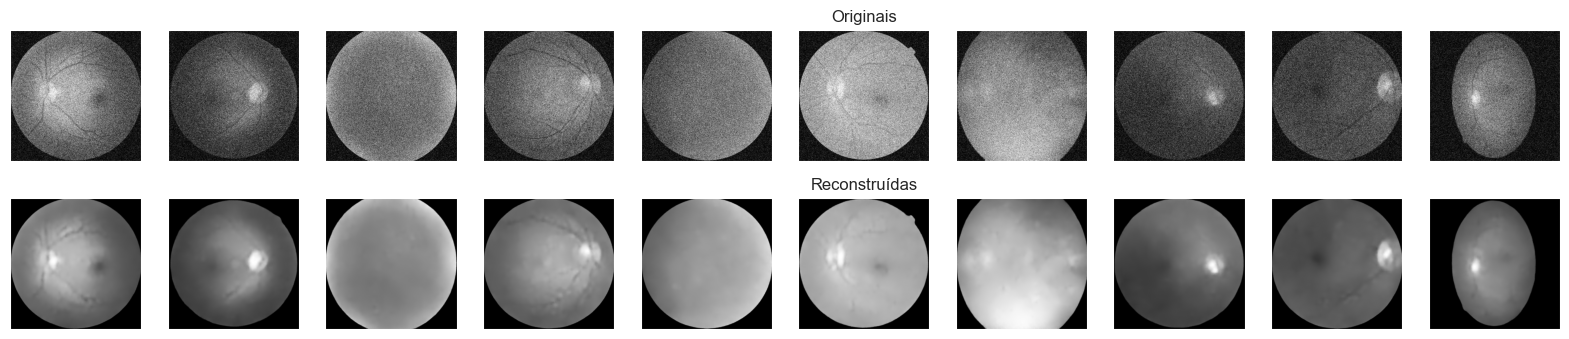


--- Congelando e salvando o encoder ---
Encoder Denoising Profundo congelado e salvo com sucesso em 'frozen_deep_denoising_encoder.pth'!

--- Exemplo de como carregar o encoder denoising profundo ---
Os parâmetros do encoder carregado estão congelados? False


In [12]:
# Lembre-se de incluir as outras importações necessárias (Subset, sklearn, etc.) se for usar a divisão estratificada.

# Supondo que suas configurações (EPOCHS, LEARNING_RATE, etc.) e os DataLoaders já estejam definidos.


# --- 1. DEFINIÇÃO DO MODELO DENOISING PROFUNDO ---
class DeepDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DeepDenoisingAutoencoder, self).__init__()
        # Encoder com 5 camadas para comprimir de 512x512 para 16x16
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 512, 512]
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),       # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),      # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),      # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),     # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),    # -> [N, 256, 16, 16] (Gargalo)
            nn.ReLU(),
        )
        # Decoder com 5 camadas para reconstruir de 16x16 para 512x512
        self.decoder = nn.Sequential(
            # Entrada: [N, 256, 16, 16]
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- 2. TREINAMENTO DO MODELO PROFUNDO COM MÉTRICAS ---
model_deep_denoising = DeepDenoisingAutoencoder().to(DEVICE) # MUDANÇA: Instancia o novo modelo
criterion = nn.L1Loss()
optimizer = optim.Adam(model_deep_denoising.parameters(), lr=LEARNING_RATE)
noise_factor = 0.4

# Instanciar os objetos das métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss = 0
    model_deep_denoising.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        noisy_images = images + noise_factor * torch.randn(*images.shape, device=DEVICE)
        noisy_images = torch.clamp(noisy_images, -1., 1.)

        outputs = model_deep_denoising(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss / len(train_loader)

    print(f"Deep Denoising AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados do Denoising Autoencoder Profundo ---")
model_deep_denoising.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    noisy_test_images = test_images + noise_factor * torch.randn(*test_images.shape, device=DEVICE)
    noisy_test_images = torch.clamp(noisy_test_images, -1., 1.)

    reconstructed_images = model_deep_denoising(noisy_test_images)

    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(noisy_test_images, reconstructed_images)

# --- 4. CONGELAR E SALVAR O ENCODER TREINADO ---
print("\n--- Congelando e salvando o encoder ---")
trained_encoder = model_deep_denoising.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_deep_denoising_encoder.pth')
print("Encoder Denoising Profundo congelado e salvo com sucesso em 'frozen_deep_denoising_encoder.pth'!")

# --- 5. (BÔNUS) Exemplo de Como Carregar e Usar o Encoder Depois ---
print("\n--- Exemplo de como carregar o encoder denoising profundo ---")
# MUDANÇA: A arquitetura a ser definida deve ser a profunda de 5 camadas
encoder_architecture = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
)

loaded_encoder = encoder_architecture
loaded_encoder.load_state_dict(torch.load('frozen_deep_denoising_encoder.pth'))
loaded_encoder.to(DEVICE)
loaded_encoder.eval()
is_frozen = all(not param.requires_grad for param in loaded_encoder.parameters())
print(f"Os parâmetros do encoder carregado estão congelados? {is_frozen}")

VAE Autoencoder

Epoch 1/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [1/200], Loss: 94724.9729, Recon: 82499.1657, KLD: 122258.0747, PSNR: 13.30 dB, SSIM: 0.1739, NRMSE: -1.1396


Epoch 2/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [2/200], Loss: 47946.0388, Recon: 47926.3365, KLD: 197.0250, PSNR: 16.91 dB, SSIM: 0.4418, NRMSE: -0.7523


Epoch 3/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [3/200], Loss: 43319.8300, Recon: 43283.1969, KLD: 366.3328, PSNR: 17.54 dB, SSIM: 0.4965, NRMSE: -0.6993


Epoch 4/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [4/200], Loss: 36439.8286, Recon: 36398.3029, KLD: 415.2625, PSNR: 18.49 dB, SSIM: 0.5328, NRMSE: -0.6268


Epoch 5/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [5/200], Loss: 31165.2429, Recon: 31122.6587, KLD: 425.8389, PSNR: 19.82 dB, SSIM: 0.6199, NRMSE: -0.5379


Epoch 6/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [6/200], Loss: 29834.3455, Recon: 29800.0899, KLD: 342.5568, PSNR: 20.51 dB, SSIM: 0.6555, NRMSE: -0.4967


Epoch 7/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [7/200], Loss: 24198.8471, Recon: 24162.0782, KLD: 367.6883, PSNR: 21.85 dB, SSIM: 0.7192, NRMSE: -0.4257


Epoch 8/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [8/200], Loss: 21610.4496, Recon: 21574.9308, KLD: 355.1875, PSNR: 22.62 dB, SSIM: 0.7406, NRMSE: -0.3897


Epoch 9/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [9/200], Loss: 21638.8454, Recon: 21604.1311, KLD: 347.1443, PSNR: 22.73 dB, SSIM: 0.7488, NRMSE: -0.3849


Epoch 10/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [10/200], Loss: 20225.3832, Recon: 20192.4688, KLD: 329.1435, PSNR: 23.20 dB, SSIM: 0.7540, NRMSE: -0.3644


Epoch 11/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [11/200], Loss: 20052.5103, Recon: 20019.0235, KLD: 334.8665, PSNR: 23.29 dB, SSIM: 0.7509, NRMSE: -0.3606


Epoch 12/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [12/200], Loss: 21398.0817, Recon: 21361.1371, KLD: 369.4461, PSNR: 22.94 dB, SSIM: 0.7561, NRMSE: -0.3757


Epoch 13/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [13/200], Loss: 19254.2854, Recon: 19222.3742, KLD: 319.1115, PSNR: 23.40 dB, SSIM: 0.7624, NRMSE: -0.3561


Epoch 14/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [14/200], Loss: 17854.4404, Recon: 17824.7926, KLD: 296.4779, PSNR: 23.99 dB, SSIM: 0.7774, NRMSE: -0.3327


Epoch 15/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [15/200], Loss: 16815.2587, Recon: 16784.4019, KLD: 308.5685, PSNR: 24.26 dB, SSIM: 0.7857, NRMSE: -0.3227


Epoch 16/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [16/200], Loss: 17857.3574, Recon: 17827.0804, KLD: 302.7692, PSNR: 24.14 dB, SSIM: 0.7796, NRMSE: -0.3271


Epoch 17/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [17/200], Loss: 17049.6408, Recon: 17019.6047, KLD: 300.3607, PSNR: 24.43 dB, SSIM: 0.7854, NRMSE: -0.3165


Epoch 18/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [18/200], Loss: 18353.1185, Recon: 18321.7825, KLD: 313.3599, PSNR: 24.01 dB, SSIM: 0.7725, NRMSE: -0.3322


Epoch 19/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [19/200], Loss: 18821.7398, Recon: 18790.7568, KLD: 309.8316, PSNR: 23.95 dB, SSIM: 0.7714, NRMSE: -0.3344


Epoch 20/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [20/200], Loss: 15328.5074, Recon: 15298.4724, KLD: 300.3492, PSNR: 24.82 dB, SSIM: 0.7993, NRMSE: -0.3024


Epoch 21/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [21/200], Loss: 15714.5024, Recon: 15685.7679, KLD: 287.3466, PSNR: 24.81 dB, SSIM: 0.7996, NRMSE: -0.3029


Epoch 22/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [22/200], Loss: 14875.2798, Recon: 14846.9953, KLD: 282.8445, PSNR: 25.08 dB, SSIM: 0.8033, NRMSE: -0.2935


Epoch 23/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [23/200], Loss: 15182.9648, Recon: 15154.6011, KLD: 283.6368, PSNR: 25.11 dB, SSIM: 0.8045, NRMSE: -0.2926


Epoch 24/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [24/200], Loss: 14593.0744, Recon: 14565.6400, KLD: 274.3432, PSNR: 25.40 dB, SSIM: 0.8123, NRMSE: -0.2828


Epoch 25/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [25/200], Loss: 14523.7954, Recon: 14496.9346, KLD: 268.6083, PSNR: 25.47 dB, SSIM: 0.8135, NRMSE: -0.2807


Epoch 26/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [26/200], Loss: 14420.7542, Recon: 14394.6634, KLD: 260.9069, PSNR: 25.56 dB, SSIM: 0.8118, NRMSE: -0.2777


Epoch 27/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [27/200], Loss: 15779.6531, Recon: 15752.5128, KLD: 271.4024, PSNR: 25.13 dB, SSIM: 0.8027, NRMSE: -0.2919


Epoch 28/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [28/200], Loss: 15138.2683, Recon: 15110.8054, KLD: 274.6286, PSNR: 25.37 dB, SSIM: 0.8109, NRMSE: -0.2838


Epoch 29/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [29/200], Loss: 14119.9755, Recon: 14092.8469, KLD: 271.2869, PSNR: 25.46 dB, SSIM: 0.8129, NRMSE: -0.2811


Epoch 30/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [30/200], Loss: 14059.9695, Recon: 14032.2118, KLD: 277.5759, PSNR: 25.52 dB, SSIM: 0.8119, NRMSE: -0.2790


Epoch 31/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [31/200], Loss: 13534.3105, Recon: 13506.9215, KLD: 273.8908, PSNR: 25.75 dB, SSIM: 0.8183, NRMSE: -0.2718


Epoch 32/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [32/200], Loss: 14002.5111, Recon: 13974.1334, KLD: 283.7770, PSNR: 25.66 dB, SSIM: 0.8066, NRMSE: -0.2748


Epoch 33/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [33/200], Loss: 14458.2610, Recon: 14429.2573, KLD: 290.0382, PSNR: 25.40 dB, SSIM: 0.8061, NRMSE: -0.2829


Epoch 34/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [34/200], Loss: 14070.7096, Recon: 14043.5999, KLD: 271.0969, PSNR: 25.62 dB, SSIM: 0.8159, NRMSE: -0.2758


Epoch 35/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [35/200], Loss: 12927.3482, Recon: 12899.8518, KLD: 274.9643, PSNR: 26.13 dB, SSIM: 0.8230, NRMSE: -0.2602


Epoch 36/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [36/200], Loss: 15178.7125, Recon: 15152.1880, KLD: 265.2442, PSNR: 25.55 dB, SSIM: 0.8141, NRMSE: -0.2780


Epoch 37/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [37/200], Loss: 13106.1406, Recon: 13079.5850, KLD: 265.5570, PSNR: 26.16 dB, SSIM: 0.8215, NRMSE: -0.2592


Epoch 38/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [38/200], Loss: 13704.1005, Recon: 13677.1555, KLD: 269.4500, PSNR: 25.89 dB, SSIM: 0.8162, NRMSE: -0.2675


Epoch 39/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [39/200], Loss: 13453.1120, Recon: 13426.1340, KLD: 269.7788, PSNR: 26.16 dB, SSIM: 0.8175, NRMSE: -0.2591


Epoch 40/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [40/200], Loss: 13880.2134, Recon: 13854.3493, KLD: 258.6419, PSNR: 26.07 dB, SSIM: 0.8198, NRMSE: -0.2621


Epoch 41/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [41/200], Loss: 12060.6274, Recon: 12035.0421, KLD: 255.8519, PSNR: 26.77 dB, SSIM: 0.8348, NRMSE: -0.2418


Epoch 42/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [42/200], Loss: 14155.4765, Recon: 14130.9204, KLD: 245.5599, PSNR: 26.07 dB, SSIM: 0.8213, NRMSE: -0.2620


Epoch 43/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [43/200], Loss: 12166.1014, Recon: 12140.9926, KLD: 251.0883, PSNR: 26.54 dB, SSIM: 0.8302, NRMSE: -0.2482


Epoch 44/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [44/200], Loss: 12602.5652, Recon: 12577.4440, KLD: 251.2127, PSNR: 26.62 dB, SSIM: 0.8295, NRMSE: -0.2458


Epoch 45/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [45/200], Loss: 12210.1324, Recon: 12185.1614, KLD: 249.7103, PSNR: 26.84 dB, SSIM: 0.8328, NRMSE: -0.2398


Epoch 46/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [46/200], Loss: 12141.7809, Recon: 12117.2633, KLD: 245.1760, PSNR: 26.91 dB, SSIM: 0.8345, NRMSE: -0.2379


Epoch 47/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [47/200], Loss: 11845.8709, Recon: 11821.6807, KLD: 241.9017, PSNR: 27.05 dB, SSIM: 0.8386, NRMSE: -0.2341


Epoch 48/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [48/200], Loss: 11659.4181, Recon: 11635.2881, KLD: 241.3003, PSNR: 27.17 dB, SSIM: 0.8400, NRMSE: -0.2308


Epoch 49/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [49/200], Loss: 12546.9135, Recon: 12522.8244, KLD: 240.8914, PSNR: 26.78 dB, SSIM: 0.8320, NRMSE: -0.2414


Epoch 50/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [50/200], Loss: 11128.6389, Recon: 11103.6451, KLD: 249.9380, PSNR: 27.09 dB, SSIM: 0.8415, NRMSE: -0.2330


Epoch 51/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [51/200], Loss: 11187.7896, Recon: 11163.0138, KLD: 247.7567, PSNR: 27.19 dB, SSIM: 0.8413, NRMSE: -0.2303


Epoch 52/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [52/200], Loss: 11639.3691, Recon: 11615.0617, KLD: 243.0734, PSNR: 27.29 dB, SSIM: 0.8410, NRMSE: -0.2277


Epoch 53/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [53/200], Loss: 10917.3354, Recon: 10892.9603, KLD: 243.7509, PSNR: 27.57 dB, SSIM: 0.8460, NRMSE: -0.2203


Epoch 54/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [54/200], Loss: 11431.4197, Recon: 11406.4083, KLD: 250.1140, PSNR: 27.25 dB, SSIM: 0.8426, NRMSE: -0.2286


Epoch 55/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [55/200], Loss: 10936.8188, Recon: 10912.2752, KLD: 245.4349, PSNR: 27.65 dB, SSIM: 0.8466, NRMSE: -0.2184


Epoch 56/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [56/200], Loss: 11124.2349, Recon: 11100.4398, KLD: 237.9501, PSNR: 27.69 dB, SSIM: 0.8444, NRMSE: -0.2174


Epoch 57/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [57/200], Loss: 10953.2425, Recon: 10929.3279, KLD: 239.1454, PSNR: 27.66 dB, SSIM: 0.8454, NRMSE: -0.2180


Epoch 58/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [58/200], Loss: 14077.2707, Recon: 14052.9674, KLD: 243.0333, PSNR: 26.02 dB, SSIM: 0.8192, NRMSE: -0.2635


Epoch 59/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [59/200], Loss: 12241.2057, Recon: 12216.0813, KLD: 251.2419, PSNR: 27.03 dB, SSIM: 0.8365, NRMSE: -0.2346


Epoch 60/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [60/200], Loss: 11548.1410, Recon: 11524.1012, KLD: 240.3974, PSNR: 27.35 dB, SSIM: 0.8413, NRMSE: -0.2261


Epoch 61/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [61/200], Loss: 10855.3203, Recon: 10831.4961, KLD: 238.2427, PSNR: 27.88 dB, SSIM: 0.8486, NRMSE: -0.2126


Epoch 62/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [62/200], Loss: 10729.2625, Recon: 10705.9857, KLD: 232.7681, PSNR: 28.06 dB, SSIM: 0.8493, NRMSE: -0.2083


Epoch 63/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [63/200], Loss: 10555.5781, Recon: 10532.1217, KLD: 234.5638, PSNR: 28.00 dB, SSIM: 0.8476, NRMSE: -0.2097


Epoch 64/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [64/200], Loss: 11050.6186, Recon: 11027.1149, KLD: 235.0372, PSNR: 27.86 dB, SSIM: 0.8487, NRMSE: -0.2131


Epoch 65/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [65/200], Loss: 10486.4250, Recon: 10462.2096, KLD: 242.1537, PSNR: 28.10 dB, SSIM: 0.8516, NRMSE: -0.2074


Epoch 66/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [66/200], Loss: 10302.6577, Recon: 10278.6214, KLD: 240.3629, PSNR: 28.08 dB, SSIM: 0.8503, NRMSE: -0.2079


Epoch 67/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [67/200], Loss: 10179.1478, Recon: 10154.8772, KLD: 242.7057, PSNR: 28.20 dB, SSIM: 0.8516, NRMSE: -0.2049


Epoch 68/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [68/200], Loss: 10810.9413, Recon: 10787.0860, KLD: 238.5537, PSNR: 27.86 dB, SSIM: 0.8476, NRMSE: -0.2131


Epoch 69/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [69/200], Loss: 10095.9877, Recon: 10072.5385, KLD: 234.4923, PSNR: 28.38 dB, SSIM: 0.8545, NRMSE: -0.2009


Epoch 70/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [70/200], Loss: 10223.9145, Recon: 10199.9976, KLD: 239.1699, PSNR: 28.36 dB, SSIM: 0.8523, NRMSE: -0.2014


Epoch 71/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [71/200], Loss: 10538.0488, Recon: 10514.7270, KLD: 233.2179, PSNR: 28.34 dB, SSIM: 0.8507, NRMSE: -0.2018


Epoch 72/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [72/200], Loss: 10031.3417, Recon: 10007.6093, KLD: 237.3245, PSNR: 28.59 dB, SSIM: 0.8555, NRMSE: -0.1961


Epoch 73/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [73/200], Loss: 9903.5456, Recon: 9879.7918, KLD: 237.5367, PSNR: 28.83 dB, SSIM: 0.8574, NRMSE: -0.1906


Epoch 74/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [74/200], Loss: 9893.1407, Recon: 9869.1811, KLD: 239.5959, PSNR: 28.69 dB, SSIM: 0.8578, NRMSE: -0.1936


Epoch 75/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [75/200], Loss: 10539.3265, Recon: 10515.3482, KLD: 239.7823, PSNR: 28.47 dB, SSIM: 0.8526, NRMSE: -0.1987


Epoch 76/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [76/200], Loss: 10039.2794, Recon: 10016.2216, KLD: 230.5776, PSNR: 28.91 dB, SSIM: 0.8563, NRMSE: -0.1889


Epoch 77/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [77/200], Loss: 9676.0525, Recon: 9653.1574, KLD: 228.9521, PSNR: 29.14 dB, SSIM: 0.8617, NRMSE: -0.1839


Epoch 78/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [78/200], Loss: 9788.5519, Recon: 9765.8035, KLD: 227.4834, PSNR: 29.17 dB, SSIM: 0.8595, NRMSE: -0.1834


Epoch 79/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [79/200], Loss: 9750.2496, Recon: 9727.4608, KLD: 227.8877, PSNR: 29.17 dB, SSIM: 0.8598, NRMSE: -0.1834


Epoch 80/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [80/200], Loss: 9569.4676, Recon: 9546.7357, KLD: 227.3200, PSNR: 29.31 dB, SSIM: 0.8626, NRMSE: -0.1804


Epoch 81/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [81/200], Loss: 9480.0092, Recon: 9457.4185, KLD: 225.9059, PSNR: 29.40 dB, SSIM: 0.8637, NRMSE: -0.1785


Epoch 82/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [82/200], Loss: 9864.8062, Recon: 9842.1174, KLD: 226.8875, PSNR: 29.04 dB, SSIM: 0.8576, NRMSE: -0.1861


Epoch 83/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [83/200], Loss: 9127.5450, Recon: 9104.1602, KLD: 233.8483, PSNR: 29.16 dB, SSIM: 0.8633, NRMSE: -0.1835


Epoch 84/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [84/200], Loss: 10640.9226, Recon: 10617.4293, KLD: 234.9326, PSNR: 28.11 dB, SSIM: 0.8505, NRMSE: -0.2071


Epoch 85/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [85/200], Loss: 9520.6800, Recon: 9497.7910, KLD: 228.8899, PSNR: 28.90 dB, SSIM: 0.8585, NRMSE: -0.1892


Epoch 86/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [86/200], Loss: 10245.5772, Recon: 10222.5065, KLD: 230.7081, PSNR: 28.55 dB, SSIM: 0.8483, NRMSE: -0.1968


Epoch 87/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [87/200], Loss: 9365.4493, Recon: 9342.6288, KLD: 228.2047, PSNR: 29.14 dB, SSIM: 0.8607, NRMSE: -0.1841


Epoch 88/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [88/200], Loss: 10284.2568, Recon: 10261.8792, KLD: 223.7764, PSNR: 28.72 dB, SSIM: 0.8542, NRMSE: -0.1932


Epoch 89/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [89/200], Loss: 9459.9945, Recon: 9437.3200, KLD: 226.7453, PSNR: 29.19 dB, SSIM: 0.8649, NRMSE: -0.1830


Epoch 90/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [90/200], Loss: 11362.8196, Recon: 11339.8489, KLD: 229.7062, PSNR: 27.37 dB, SSIM: 0.8397, NRMSE: -0.2256


Epoch 91/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [91/200], Loss: 9845.1512, Recon: 9822.5210, KLD: 226.3016, PSNR: 28.73 dB, SSIM: 0.8582, NRMSE: -0.1928


Epoch 92/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [92/200], Loss: 9371.3206, Recon: 9348.5724, KLD: 227.4812, PSNR: 29.39 dB, SSIM: 0.8636, NRMSE: -0.1787


Epoch 93/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [93/200], Loss: 9903.5788, Recon: 9880.7089, KLD: 228.6995, PSNR: 28.94 dB, SSIM: 0.8563, NRMSE: -0.1882


Epoch 94/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [94/200], Loss: 9519.7791, Recon: 9497.2674, KLD: 225.1174, PSNR: 29.36 dB, SSIM: 0.8637, NRMSE: -0.1794


Epoch 95/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [95/200], Loss: 8781.1890, Recon: 8758.2260, KLD: 229.6297, PSNR: 29.80 dB, SSIM: 0.8685, NRMSE: -0.1704


Epoch 96/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [96/200], Loss: 8537.6201, Recon: 8514.5616, KLD: 230.5846, PSNR: 29.97 dB, SSIM: 0.8708, NRMSE: -0.1673


Epoch 97/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [97/200], Loss: 10801.1294, Recon: 10778.4075, KLD: 227.2180, PSNR: 28.97 dB, SSIM: 0.8561, NRMSE: -0.1877


Epoch 98/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [98/200], Loss: 8972.4310, Recon: 8949.8527, KLD: 225.7841, PSNR: 29.81 dB, SSIM: 0.8675, NRMSE: -0.1703


Epoch 99/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [99/200], Loss: 9202.1036, Recon: 9179.2173, KLD: 228.8625, PSNR: 29.70 dB, SSIM: 0.8673, NRMSE: -0.1725


Epoch 100/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [100/200], Loss: 9105.1618, Recon: 9081.9404, KLD: 232.2139, PSNR: 29.77 dB, SSIM: 0.8692, NRMSE: -0.1712


Epoch 101/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [101/200], Loss: 9048.5999, Recon: 9025.8289, KLD: 227.7108, PSNR: 29.95 dB, SSIM: 0.8672, NRMSE: -0.1677


Epoch 102/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [102/200], Loss: 9133.2221, Recon: 9110.4129, KLD: 228.0914, PSNR: 29.71 dB, SSIM: 0.8681, NRMSE: -0.1722


Epoch 103/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [103/200], Loss: 8937.6527, Recon: 8915.1867, KLD: 224.6597, PSNR: 29.99 dB, SSIM: 0.8696, NRMSE: -0.1667


Epoch 104/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [104/200], Loss: 8723.2033, Recon: 8700.6644, KLD: 225.3888, PSNR: 30.15 dB, SSIM: 0.8720, NRMSE: -0.1638


Epoch 105/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [105/200], Loss: 8525.5693, Recon: 8502.8956, KLD: 226.7362, PSNR: 30.04 dB, SSIM: 0.8712, NRMSE: -0.1658


Epoch 106/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [106/200], Loss: 9005.7313, Recon: 8982.5916, KLD: 231.3971, PSNR: 29.44 dB, SSIM: 0.8662, NRMSE: -0.1777


Epoch 107/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [107/200], Loss: 8913.2118, Recon: 8889.9937, KLD: 232.1813, PSNR: 29.72 dB, SSIM: 0.8676, NRMSE: -0.1721


Epoch 108/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [108/200], Loss: 9104.9866, Recon: 9081.7246, KLD: 232.6197, PSNR: 29.61 dB, SSIM: 0.8645, NRMSE: -0.1743


Epoch 109/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [109/200], Loss: 10012.1082, Recon: 9988.6962, KLD: 234.1202, PSNR: 28.80 dB, SSIM: 0.8561, NRMSE: -0.1912


Epoch 110/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [110/200], Loss: 9097.6965, Recon: 9074.9481, KLD: 227.4842, PSNR: 29.81 dB, SSIM: 0.8679, NRMSE: -0.1703


Epoch 111/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [111/200], Loss: 8780.7491, Recon: 8757.8939, KLD: 228.5523, PSNR: 30.13 dB, SSIM: 0.8706, NRMSE: -0.1641


Epoch 112/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [112/200], Loss: 8698.3636, Recon: 8676.0746, KLD: 222.8903, PSNR: 30.24 dB, SSIM: 0.8721, NRMSE: -0.1620


Epoch 113/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [113/200], Loss: 8616.2586, Recon: 8593.6948, KLD: 225.6383, PSNR: 30.33 dB, SSIM: 0.8732, NRMSE: -0.1605


Epoch 114/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [114/200], Loss: 8566.4706, Recon: 8544.0812, KLD: 223.8938, PSNR: 30.40 dB, SSIM: 0.8728, NRMSE: -0.1591


Epoch 115/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [115/200], Loss: 8532.0649, Recon: 8509.5245, KLD: 225.4034, PSNR: 30.44 dB, SSIM: 0.8737, NRMSE: -0.1584


Epoch 116/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [116/200], Loss: 8029.0670, Recon: 8006.7106, KLD: 223.5633, PSNR: 30.53 dB, SSIM: 0.8763, NRMSE: -0.1568


Epoch 117/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [117/200], Loss: 7899.9958, Recon: 7877.2530, KLD: 227.4279, PSNR: 30.61 dB, SSIM: 0.8776, NRMSE: -0.1553


Epoch 118/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [118/200], Loss: 8624.8245, Recon: 8602.1592, KLD: 226.6531, PSNR: 30.05 dB, SSIM: 0.8713, NRMSE: -0.1657


Epoch 119/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [119/200], Loss: 8772.6728, Recon: 8750.0784, KLD: 225.9440, PSNR: 30.07 dB, SSIM: 0.8717, NRMSE: -0.1653


Epoch 120/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [120/200], Loss: 8125.1450, Recon: 8102.3501, KLD: 227.9495, PSNR: 30.31 dB, SSIM: 0.8756, NRMSE: -0.1608


Epoch 121/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [121/200], Loss: 9213.5946, Recon: 9190.4279, KLD: 231.6664, PSNR: 29.37 dB, SSIM: 0.8647, NRMSE: -0.1791


Epoch 122/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [122/200], Loss: 9570.2421, Recon: 9547.5342, KLD: 227.0792, PSNR: 29.14 dB, SSIM: 0.8618, NRMSE: -0.1840


Epoch 123/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [123/200], Loss: 8698.1691, Recon: 8675.5327, KLD: 226.3640, PSNR: 29.66 dB, SSIM: 0.8679, NRMSE: -0.1732


Epoch 124/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [124/200], Loss: 9251.3812, Recon: 9228.3737, KLD: 230.0739, PSNR: 29.49 dB, SSIM: 0.8644, NRMSE: -0.1767


Epoch 125/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [125/200], Loss: 8554.6070, Recon: 8531.4468, KLD: 231.6014, PSNR: 30.06 dB, SSIM: 0.8725, NRMSE: -0.1655


Epoch 126/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [126/200], Loss: 9029.3861, Recon: 9005.7918, KLD: 235.9425, PSNR: 29.44 dB, SSIM: 0.8640, NRMSE: -0.1778


Epoch 127/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [127/200], Loss: 8381.1455, Recon: 8357.3418, KLD: 238.0378, PSNR: 30.11 dB, SSIM: 0.8629, NRMSE: -0.1644


Epoch 128/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [128/200], Loss: 8280.2974, Recon: 8257.4490, KLD: 228.4834, PSNR: 30.12 dB, SSIM: 0.8712, NRMSE: -0.1643


Epoch 129/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [129/200], Loss: 9174.7656, Recon: 9152.3579, KLD: 224.0780, PSNR: 29.71 dB, SSIM: 0.8634, NRMSE: -0.1723


Epoch 130/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [130/200], Loss: 8481.8849, Recon: 8459.1112, KLD: 227.7367, PSNR: 30.33 dB, SSIM: 0.8735, NRMSE: -0.1604


Epoch 131/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [131/200], Loss: 8393.7585, Recon: 8370.9884, KLD: 227.7011, PSNR: 30.42 dB, SSIM: 0.8723, NRMSE: -0.1587


Epoch 132/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [132/200], Loss: 8084.3789, Recon: 8061.5638, KLD: 228.1518, PSNR: 30.53 dB, SSIM: 0.8744, NRMSE: -0.1567


Epoch 133/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [133/200], Loss: 8591.0669, Recon: 8567.9947, KLD: 230.7217, PSNR: 30.17 dB, SSIM: 0.8691, NRMSE: -0.1635


Epoch 134/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [134/200], Loss: 8262.1134, Recon: 8239.3993, KLD: 227.1407, PSNR: 30.54 dB, SSIM: 0.8765, NRMSE: -0.1565


Epoch 135/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [135/200], Loss: 8349.5172, Recon: 8326.5129, KLD: 230.0440, PSNR: 30.44 dB, SSIM: 0.8738, NRMSE: -0.1583


Epoch 136/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [136/200], Loss: 9016.5827, Recon: 8993.4318, KLD: 231.5084, PSNR: 29.42 dB, SSIM: 0.8645, NRMSE: -0.1780


Epoch 137/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [137/200], Loss: 8506.0790, Recon: 8483.0256, KLD: 230.5351, PSNR: 30.29 dB, SSIM: 0.8738, NRMSE: -0.1612


Epoch 138/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [138/200], Loss: 8188.6664, Recon: 8165.5410, KLD: 231.2536, PSNR: 30.80 dB, SSIM: 0.8787, NRMSE: -0.1520


Epoch 139/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [139/200], Loss: 8017.7075, Recon: 7994.9173, KLD: 227.9014, PSNR: 30.98 dB, SSIM: 0.8800, NRMSE: -0.1488


Epoch 140/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [140/200], Loss: 7988.7369, Recon: 7966.3114, KLD: 224.2565, PSNR: 31.03 dB, SSIM: 0.8801, NRMSE: -0.1480


Epoch 141/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [141/200], Loss: 8051.2328, Recon: 8028.9127, KLD: 223.2009, PSNR: 31.01 dB, SSIM: 0.8783, NRMSE: -0.1483


Epoch 142/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [142/200], Loss: 7736.0665, Recon: 7713.7480, KLD: 223.1855, PSNR: 31.04 dB, SSIM: 0.8806, NRMSE: -0.1478


Epoch 143/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [143/200], Loss: 9280.0052, Recon: 9257.0543, KLD: 229.5093, PSNR: 28.82 dB, SSIM: 0.8645, NRMSE: -0.1910


Epoch 144/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [144/200], Loss: 9292.1602, Recon: 9269.4244, KLD: 227.3572, PSNR: 29.23 dB, SSIM: 0.8683, NRMSE: -0.1821


Epoch 145/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [145/200], Loss: 8343.5283, Recon: 8321.1601, KLD: 223.6816, PSNR: 30.12 dB, SSIM: 0.8750, NRMSE: -0.1643


Epoch 146/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [146/200], Loss: 9243.6188, Recon: 9221.0241, KLD: 225.9475, PSNR: 28.81 dB, SSIM: 0.8665, NRMSE: -0.1911


Epoch 147/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [147/200], Loss: 8126.0895, Recon: 8103.1680, KLD: 229.2154, PSNR: 29.77 dB, SSIM: 0.8766, NRMSE: -0.1711


Epoch 148/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [148/200], Loss: 7792.8930, Recon: 7769.9079, KLD: 229.8500, PSNR: 30.39 dB, SSIM: 0.8804, NRMSE: -0.1593


Epoch 149/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [149/200], Loss: 7576.4398, Recon: 7553.6485, KLD: 227.9133, PSNR: 30.84 dB, SSIM: 0.8825, NRMSE: -0.1513


Epoch 150/200: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]


VAE | Epoch [150/200], Loss: 7853.5262, Recon: 7830.9772, KLD: 225.4896, PSNR: 30.80 dB, SSIM: 0.8800, NRMSE: -0.1519


Epoch 151/200: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]


VAE | Epoch [151/200], Loss: 8984.1292, Recon: 8962.0410, KLD: 220.8831, PSNR: 30.04 dB, SSIM: 0.8700, NRMSE: -0.1659


Epoch 152/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [152/200], Loss: 8316.7280, Recon: 8294.3094, KLD: 224.1870, PSNR: 30.43 dB, SSIM: 0.8732, NRMSE: -0.1586


Epoch 153/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [153/200], Loss: 7655.0650, Recon: 7632.5391, KLD: 225.2590, PSNR: 30.86 dB, SSIM: 0.8806, NRMSE: -0.1509


Epoch 154/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [154/200], Loss: 8472.7279, Recon: 8449.6819, KLD: 230.4590, PSNR: 29.76 dB, SSIM: 0.8722, NRMSE: -0.1712


Epoch 155/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [155/200], Loss: 8537.6364, Recon: 8514.8341, KLD: 228.0229, PSNR: 30.06 dB, SSIM: 0.8734, NRMSE: -0.1655


Epoch 156/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [156/200], Loss: 8066.0620, Recon: 8043.4236, KLD: 226.3840, PSNR: 30.60 dB, SSIM: 0.8771, NRMSE: -0.1556


Epoch 157/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [157/200], Loss: 7976.4633, Recon: 7953.8427, KLD: 226.2062, PSNR: 30.87 dB, SSIM: 0.8793, NRMSE: -0.1508


Epoch 158/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [158/200], Loss: 7964.6503, Recon: 7942.2457, KLD: 224.0454, PSNR: 31.03 dB, SSIM: 0.8805, NRMSE: -0.1479


Epoch 159/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [159/200], Loss: 7899.1139, Recon: 7876.9147, KLD: 221.9925, PSNR: 31.10 dB, SSIM: 0.8813, NRMSE: -0.1468


Epoch 160/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [160/200], Loss: 7803.0031, Recon: 7780.9196, KLD: 220.8348, PSNR: 31.22 dB, SSIM: 0.8824, NRMSE: -0.1449


Epoch 161/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [161/200], Loss: 7792.4517, Recon: 7770.2520, KLD: 221.9968, PSNR: 31.17 dB, SSIM: 0.8818, NRMSE: -0.1456


Epoch 162/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [162/200], Loss: 7952.2258, Recon: 7930.1370, KLD: 220.8877, PSNR: 30.58 dB, SSIM: 0.8748, NRMSE: -0.1558


Epoch 163/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [163/200], Loss: 8258.7615, Recon: 8236.2791, KLD: 224.8243, PSNR: 30.44 dB, SSIM: 0.8755, NRMSE: -0.1584


Epoch 164/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [164/200], Loss: 8345.8225, Recon: 8323.4491, KLD: 223.7345, PSNR: 30.39 dB, SSIM: 0.8746, NRMSE: -0.1594


Epoch 165/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [165/200], Loss: 7917.3210, Recon: 7894.7561, KLD: 225.6477, PSNR: 30.80 dB, SSIM: 0.8786, NRMSE: -0.1519


Epoch 166/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [166/200], Loss: 7753.7239, Recon: 7731.4058, KLD: 223.1806, PSNR: 30.63 dB, SSIM: 0.8782, NRMSE: -0.1549


Epoch 167/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [167/200], Loss: 8155.4469, Recon: 8133.0772, KLD: 223.6971, PSNR: 30.27 dB, SSIM: 0.8744, NRMSE: -0.1615


Epoch 168/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [168/200], Loss: 7461.1427, Recon: 7438.7292, KLD: 224.1347, PSNR: 31.22 dB, SSIM: 0.8830, NRMSE: -0.1448


Epoch 169/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [169/200], Loss: 7982.3506, Recon: 7959.9130, KLD: 224.3766, PSNR: 30.50 dB, SSIM: 0.8769, NRMSE: -0.1572


Epoch 170/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [170/200], Loss: 9162.6266, Recon: 9140.4874, KLD: 221.3920, PSNR: 29.90 dB, SSIM: 0.8662, NRMSE: -0.1685


Epoch 171/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [171/200], Loss: 7888.2595, Recon: 7865.9091, KLD: 223.5039, PSNR: 30.59 dB, SSIM: 0.8781, NRMSE: -0.1557


Epoch 172/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [172/200], Loss: 7914.8653, Recon: 7892.1994, KLD: 226.6593, PSNR: 30.79 dB, SSIM: 0.8803, NRMSE: -0.1521


Epoch 173/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [173/200], Loss: 7687.7701, Recon: 7665.2349, KLD: 225.3527, PSNR: 31.07 dB, SSIM: 0.8802, NRMSE: -0.1473


Epoch 174/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [174/200], Loss: 7726.5843, Recon: 7703.8926, KLD: 226.9158, PSNR: 31.02 dB, SSIM: 0.8809, NRMSE: -0.1481


Epoch 175/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [175/200], Loss: 7973.1627, Recon: 7950.4124, KLD: 227.5020, PSNR: 30.98 dB, SSIM: 0.8800, NRMSE: -0.1488


Epoch 176/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [176/200], Loss: 7699.5950, Recon: 7677.3317, KLD: 222.6332, PSNR: 31.33 dB, SSIM: 0.8835, NRMSE: -0.1430


Epoch 177/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [177/200], Loss: 7609.9321, Recon: 7588.0144, KLD: 219.1774, PSNR: 31.48 dB, SSIM: 0.8840, NRMSE: -0.1405


Epoch 178/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [178/200], Loss: 7488.9136, Recon: 7466.9955, KLD: 219.1809, PSNR: 31.60 dB, SSIM: 0.8862, NRMSE: -0.1386


Epoch 179/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [179/200], Loss: 7661.4497, Recon: 7639.5693, KLD: 218.8038, PSNR: 31.45 dB, SSIM: 0.8834, NRMSE: -0.1409


Epoch 180/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [180/200], Loss: 8235.3034, Recon: 8213.2976, KLD: 220.0578, PSNR: 31.00 dB, SSIM: 0.8779, NRMSE: -0.1485


Epoch 181/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [181/200], Loss: 7788.6219, Recon: 7766.5479, KLD: 220.7394, PSNR: 31.19 dB, SSIM: 0.8806, NRMSE: -0.1452


Epoch 182/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [182/200], Loss: 7217.0358, Recon: 7194.9993, KLD: 220.3647, PSNR: 31.59 dB, SSIM: 0.8852, NRMSE: -0.1388


Epoch 183/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [183/200], Loss: 8066.9500, Recon: 8044.7666, KLD: 221.8340, PSNR: 31.03 dB, SSIM: 0.8799, NRMSE: -0.1480


Epoch 184/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [184/200], Loss: 7624.1736, Recon: 7601.8295, KLD: 223.4415, PSNR: 31.11 dB, SSIM: 0.8824, NRMSE: -0.1467


Epoch 185/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [185/200], Loss: 7921.9889, Recon: 7899.7793, KLD: 222.0954, PSNR: 30.60 dB, SSIM: 0.8779, NRMSE: -0.1554


Epoch 186/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [186/200], Loss: 8123.6241, Recon: 8101.3568, KLD: 222.6731, PSNR: 30.57 dB, SSIM: 0.8771, NRMSE: -0.1560


Epoch 187/200: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


VAE | Epoch [187/200], Loss: 9059.6832, Recon: 9038.1508, KLD: 215.3238, PSNR: 29.76 dB, SSIM: 0.8674, NRMSE: -0.1713


Epoch 188/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [188/200], Loss: 7456.1951, Recon: 7433.9277, KLD: 222.6740, PSNR: 31.17 dB, SSIM: 0.8825, NRMSE: -0.1456


Epoch 189/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [189/200], Loss: 8515.0677, Recon: 8493.0927, KLD: 219.7511, PSNR: 30.11 dB, SSIM: 0.8726, NRMSE: -0.1646


Epoch 190/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [190/200], Loss: 7950.0111, Recon: 7927.9401, KLD: 220.7099, PSNR: 31.06 dB, SSIM: 0.8805, NRMSE: -0.1474


Epoch 191/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [191/200], Loss: 7774.8627, Recon: 7753.1044, KLD: 217.5818, PSNR: 31.05 dB, SSIM: 0.8813, NRMSE: -0.1477


Epoch 192/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [192/200], Loss: 8532.8990, Recon: 8510.8693, KLD: 220.2965, PSNR: 30.72 dB, SSIM: 0.8764, NRMSE: -0.1533


Epoch 193/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [193/200], Loss: 8057.0130, Recon: 8035.3515, KLD: 216.6154, PSNR: 30.78 dB, SSIM: 0.8769, NRMSE: -0.1524


Epoch 194/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [194/200], Loss: 7896.6571, Recon: 7874.6237, KLD: 220.3338, PSNR: 31.10 dB, SSIM: 0.8805, NRMSE: -0.1468


Epoch 195/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [195/200], Loss: 7202.4186, Recon: 7179.9614, KLD: 224.5721, PSNR: 31.61 dB, SSIM: 0.8855, NRMSE: -0.1384


Epoch 196/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [196/200], Loss: 7172.6620, Recon: 7150.4194, KLD: 222.4267, PSNR: 31.60 dB, SSIM: 0.8864, NRMSE: -0.1385


Epoch 197/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [197/200], Loss: 7022.3658, Recon: 7000.0685, KLD: 222.9734, PSNR: 31.59 dB, SSIM: 0.8884, NRMSE: -0.1387


Epoch 198/200: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]


VAE | Epoch [198/200], Loss: 7231.4696, Recon: 7209.1632, KLD: 223.0640, PSNR: 31.62 dB, SSIM: 0.8866, NRMSE: -0.1383


Epoch 199/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [199/200], Loss: 7190.9050, Recon: 7168.6933, KLD: 222.1166, PSNR: 31.78 dB, SSIM: 0.8878, NRMSE: -0.1358


Epoch 200/200: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]


VAE | Epoch [200/200], Loss: 7497.3025, Recon: 7475.0777, KLD: 222.2471, PSNR: 31.14 dB, SSIM: 0.8827, NRMSE: -0.1462

--- Visualizando e Avaliando resultados do VAE ---
Métricas no Lote de Teste -> PSNR: 27.85 dB | SSIM: 0.8623 | NRMSE: -0.2195


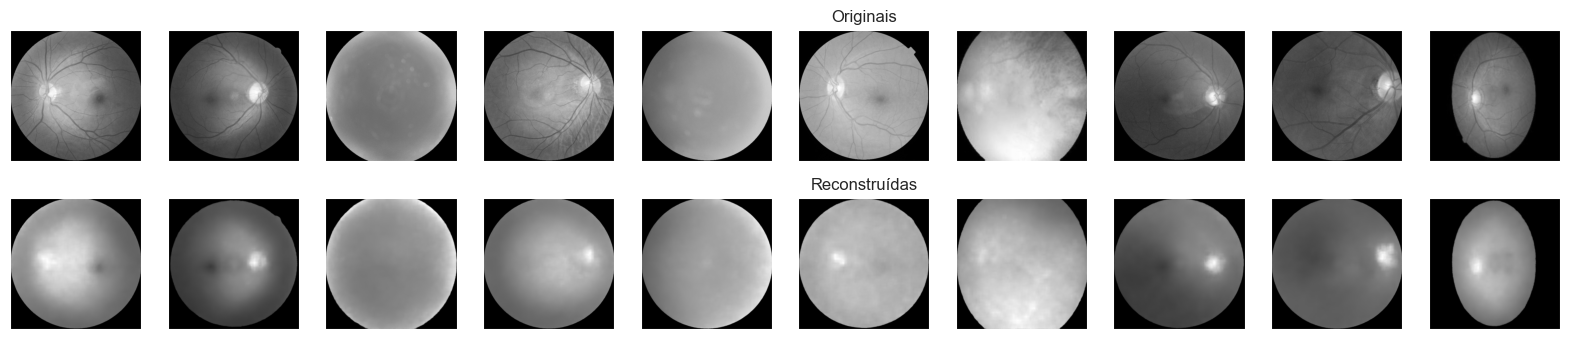


--- Congelando e salvando o encoder do VAE ---
Encoder VAE Profundo (até mu) congelado e salvo com sucesso em 'frozen_deep_vae_encoder.pth'!


In [13]:
# Supondo que suas configurações (EPOCHS, LEARNING_RATE, etc.) e os DataLoaders já estejam definidos.

# ==============================================================================
# --- 1. DEFINIÇÃO DO MODELO VAE PROFUNDO (5 CAMADAS) ---
# ==============================================================================
class ConvolutionalVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvolutionalVAE, self).__init__()

        # --- ENCODER PROFUNDO ---
        self.encoder_conv = nn.Sequential(
            # Entrada: [N, 1, 512, 512]
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),       # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),      # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),      # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),     # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),    # -> [N, 256, 16, 16] (Gargalo)
            nn.ReLU(),
        )

        # MUDANÇA: Tamanho achatado atualizado para a saída da nova rede
        self.flattened_size = 256 * 16 * 16

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(self.flattened_size, latent_dim)

        # --- DECODER PROFUNDO ---
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (256, 16, 16)), # MUDANÇA: Dimensões atualizadas
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size) # MUDANÇA: Usa o novo flattened_size
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        recon_h = self.decoder_fc(z)
        recon_x = self.decoder_conv(recon_h)
        return recon_x, mu, log_var

# --- Função de perda (sem alterações) ---
def loss_function(recon_x, x, mu, log_var, beta=0.1):
    RECON_LOSS = F.l1_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return RECON_LOSS, KLD, RECON_LOSS + beta * KLD

# --- 2. TREINAMENTO DO MODELO COM MÉTRICAS ---
model_vae = ConvolutionalVAE().to(DEVICE)
optimizer = optim.Adam(model_vae.parameters(), lr=LEARNING_RATE)

psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss, total_recon_loss, total_kld_loss = 0, 0, 0
    model_vae.train()

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, _ = data
        images = images.to(DEVICE)

        recon_images, mu, log_var = model_vae(images)
        recon_loss, kld_loss, loss = loss_function(recon_images, images, mu, log_var, beta=0.1)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vae.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kld_loss += kld_loss.item()

        psnr_metric.update(recon_images, images)
        ssim_metric.update(recon_images, images)
        nrmse_metric.update(recon_images, images)

    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon_loss / len(train_loader.dataset)
    avg_kld = total_kld_loss / len(train_loader.dataset)

    print(f"VAE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
# (Esta seção não precisa de alterações)
print("\n--- Visualizando e Avaliando resultados do VAE ---")
model_vae.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)
    reconstructed_images, _, _ = model_vae(test_images)

    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 4. CONGELAR E SALVAR O ENCODER TREINADO ---
print("\n--- Congelando e salvando o encoder do VAE ---")

# MUDANÇA: A classe VAE_Encoder precisa refletir a nova arquitetura profunda
class VAE_Encoder(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.encoder_conv = original_model.encoder_conv
        self.flattened_size = original_model.flattened_size
        self.fc_mu = original_model.fc_mu

    def forward(self, x):
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size)
        mu = self.fc_mu(h)
        return mu

trained_encoder = VAE_Encoder(model_vae).to(DEVICE)
trained_encoder.eval()

for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_deep_vae_encoder.pth') # Nome do arquivo alterado

print("Encoder VAE Profundo (até mu) congelado e salvo com sucesso em 'frozen_deep_vae_encoder.pth'!")

Reseidual Autoencoder


--- Iniciando o treinamento do Autoencoder Residual Profundo ---
Deep Residual AE | Epoch [1/200], Loss: 0.2851, PSNR: 13.56 dB, SSIM: 0.2667, NRMSE: -1.1064
Deep Residual AE | Epoch [2/200], Loss: 0.1174, PSNR: 20.74 dB, SSIM: 0.6750, NRMSE: -0.4838
Deep Residual AE | Epoch [3/200], Loss: 0.0684, PSNR: 24.07 dB, SSIM: 0.7559, NRMSE: -0.3300
Deep Residual AE | Epoch [4/200], Loss: 0.0610, PSNR: 25.09 dB, SSIM: 0.7943, NRMSE: -0.2932
Deep Residual AE | Epoch [5/200], Loss: 0.0606, PSNR: 25.69 dB, SSIM: 0.7974, NRMSE: -0.2736
Deep Residual AE | Epoch [6/200], Loss: 0.0517, PSNR: 26.64 dB, SSIM: 0.8225, NRMSE: -0.2453
Deep Residual AE | Epoch [7/200], Loss: 0.0509, PSNR: 26.62 dB, SSIM: 0.8076, NRMSE: -0.2459
Deep Residual AE | Epoch [8/200], Loss: 0.0545, PSNR: 26.80 dB, SSIM: 0.8106, NRMSE: -0.2408
Deep Residual AE | Epoch [9/200], Loss: 0.0471, PSNR: 27.73 dB, SSIM: 0.8257, NRMSE: -0.2164
Deep Residual AE | Epoch [10/200], Loss: 0.0446, PSNR: 28.03 dB, SSIM: 0.8360, NRMSE: -0.2091
Dee

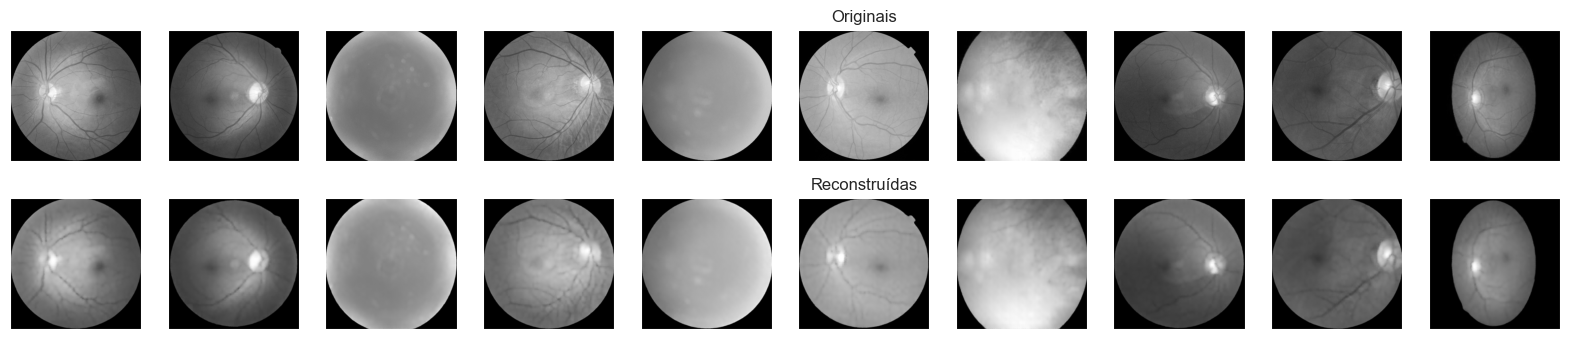


--- Congelando e salvando o encoder ---
Encoder Residual Profundo congelado e salvo com sucesso em 'frozen_deep_residual_encoder.pth'!


In [4]:
# Supondo que suas configurações (EPOCHS, LEARNING_RATE, etc.) e os DataLoaders para imagens 512x512 já estejam definidos.

# ==============================================================================
# --- 1. DEFINIÇÃO DA ARQUITETURA RESIDUAL PROFUNDA ---
# ==============================================================================

# O Bloco Residual auxiliar não precisa de alterações.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# MUDANÇA: Arquitetura principal aprofundada para 512x512
class ResidualAutoencoder(nn.Module):
    def __init__(self):
        super(ResidualAutoencoder, self).__init__()

        # --- ENCODER PROFUNDO (5 PASSOS DE DOWNSAMPLING) ---
        self.initial_conv = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False) # -> [N, 16, 256, 256]
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.res_block1 = ResidualBlock(16, 32, stride=2)   # -> [N, 32, 128, 128]
        self.res_block2 = ResidualBlock(32, 64, stride=2)   # -> [N, 64, 64, 64]
        self.res_block3 = ResidualBlock(64, 128, stride=2)  # -> [N, 128, 32, 32]
        self.res_block4 = ResidualBlock(128, 256, stride=2) # -> [N, 256, 16, 16] (Gargalo)

        # --- DECODER PROFUNDO (5 PASSOS DE UPSAMPLING) ---
        self.res_block5 = ResidualBlock(256, 256)
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # -> [N, 128, 32, 32]

        self.res_block6 = ResidualBlock(128, 128)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # -> [N, 64, 64, 64]

        self.res_block7 = ResidualBlock(64, 64)
        self.upsample3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # -> [N, 32, 128, 128]

        self.res_block8 = ResidualBlock(32, 32)
        self.upsample4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # -> [N, 16, 256, 256]

        self.upsample5 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2) # -> [N, 16, 512, 512]
        self.final_conv = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def encode(self, x):
        out = self.relu(self.bn1(self.initial_conv(x)))
        out = self.res_block1(out)
        out = self.res_block2(out)
        out = self.res_block3(out)
        out = self.res_block4(out)
        return out

    def decode(self, z):
        out = self.res_block5(z)
        out = self.upsample1(out)
        out = self.res_block6(out)
        out = self.upsample2(out)
        out = self.res_block7(out)
        out = self.upsample3(out)
        out = self.res_block8(out)
        out = self.upsample4(out)
        out = self.upsample5(out)
        out = self.final_conv(out)
        out = self.tanh(out)
        return out

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

# ==============================================================================
# --- TREINAMENTO, AVALIAÇÃO E SALVAMENTO ---
# (O código abaixo permanece o mesmo, mas usará o novo modelo profundo)
# ==============================================================================

# Apenas execute se o dataset não estiver vazio
if 'train_loader' in locals() and len(train_loader.dataset) > 0:
    # Instancia o novo modelo profundo
    model_res = ResidualAutoencoder().to(DEVICE)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model_res.parameters(), lr=LEARNING_RATE)

    psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
    nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

    print("\n--- Iniciando o treinamento do Autoencoder Residual Profundo ---")
    for epoch in range(EPOCHS):
        model_res.train()
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(DEVICE)
            outputs = model_res(images)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            psnr_metric.update(outputs, images)
            ssim_metric.update(outputs, images)
            nrmse_metric.update(outputs, images)

        epoch_psnr = psnr_metric.compute()
        epoch_ssim = ssim_metric.compute()
        epoch_nrmse = nrmse_metric.compute()
        psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()
        avg_loss = total_loss / len(train_loader)

        print(f"Deep Residual AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
              f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

    # --- Visualização e Métricas Finais no Teste ---
    print("\n--- Visualizando e Avaliando resultados no conjunto de teste ---")
    model_res.eval()
    with torch.no_grad():
        data_iter = iter(test_loader)
        test_images, _ = next(data_iter)
        test_images = test_images.to(DEVICE)
        reconstructed_images = model_res(test_images)
        psnr_val = psnr_metric(reconstructed_images, test_images)
        ssim_val = ssim_metric(reconstructed_images, test_images)
        nrmse_val = nrmse_metric(reconstructed_images, test_images)
        print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")
        plot_images(test_images, reconstructed_images)

    # --- Congelar e Salvar o Encoder Profundo ---
    print("\n--- Congelando e salvando o encoder ---")

    # MUDANÇA: O encoder agora tem mais blocos
    trained_encoder = nn.Sequential(
        model_res.initial_conv,
        model_res.bn1,
        model_res.relu,
        model_res.res_block1,
        model_res.res_block2,
        model_res.res_block3,
        model_res.res_block4 # Adicionado o novo bloco
    ).to(DEVICE)
    trained_encoder.eval()

    for param in trained_encoder.parameters():
        param.requires_grad = False

    torch.save(trained_encoder.state_dict(), 'frozen_deep_residual_encoder.pth')
    print("Encoder Residual Profundo congelado e salvo com sucesso em 'frozen_deep_residual_encoder.pth'!")

Testes

Usando dispositivo: cuda
Classes encontradas: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


A procurar ficheiros de imagem: 100%|██████████| 4/4 [00:00<00:00, 121.55it/s]



Divisão estratificada (70/30) concluída:
Conjunto de Treino: 2951 imagens
Conjunto de Teste: 1266 imagens

DataLoaders de treino e teste criados com sucesso!


Progresso Geral dos Testes:   0%|          | 0/2 [00:00<?, ?it/s]


Iniciando teste para: Shallow Encoder (3 Camadas)



Extraindo Treino (Shallow Encoder (3 Camadas)): 100%|██████████| 47/47 [00:23<00:00,  2.03it/s]

Extraindo Teste (Shallow Encoder (3 Camadas)): 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Extração concluída!
Treinando o modelo SVM Padrão (pode demorar)...
[LibSVM]
Avaliando o modelo no conjunto de teste...

--- RESULTADO FINAL PARA Shallow Encoder (3 Camadas) ---
Acurácia no conjunto de teste: 72.83%

Relatório de Classificação:
                      precision    recall  f1-score   support

            cataract       0.67      0.60      0.63       312
diabetic_retinopathy       0.97      1.00      0.99       330
            glaucoma       0.61      0.45      0.52       302
              normal       0.63      0.83      0.72       322

            accuracy                           0.73      1266
           macro avg       0.72      0.72      0.71      1266
        weighted avg       0.73      0.73      0.72      1266

Matriz de Confusão:


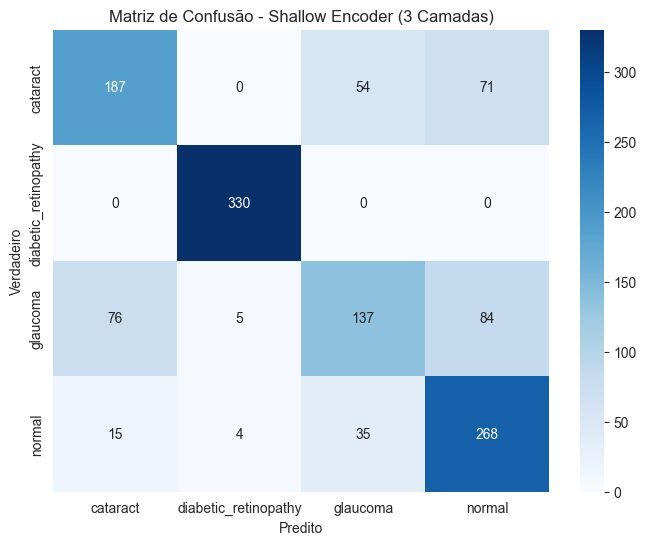

Progresso Geral dos Testes:  50%|█████     | 1/2 [36:26<36:26, 2186.66s/it]


Iniciando teste para: Deep Encoder (5 Camadas)



Extraindo Treino (Deep Encoder (5 Camadas)): 100%|██████████| 47/47 [00:24<00:00,  1.88it/s]

Extraindo Teste (Deep Encoder (5 Camadas)): 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Extração concluída!
Treinando o modelo SVM Padrão (pode demorar)...
[LibSVM]
Avaliando o modelo no conjunto de teste...

--- RESULTADO FINAL PARA Deep Encoder (5 Camadas) ---
Acurácia no conjunto de teste: 77.33%

Relatório de Classificação:
                      precision    recall  f1-score   support

            cataract       0.74      0.71      0.73       312
diabetic_retinopathy       0.97      0.99      0.98       330
            glaucoma       0.72      0.52      0.61       302
              normal       0.66      0.84      0.74       322

            accuracy                           0.77      1266
           macro avg       0.77      0.77      0.76      1266
        weighted avg       0.78      0.77      0.77      1266

Matriz de Confusão:


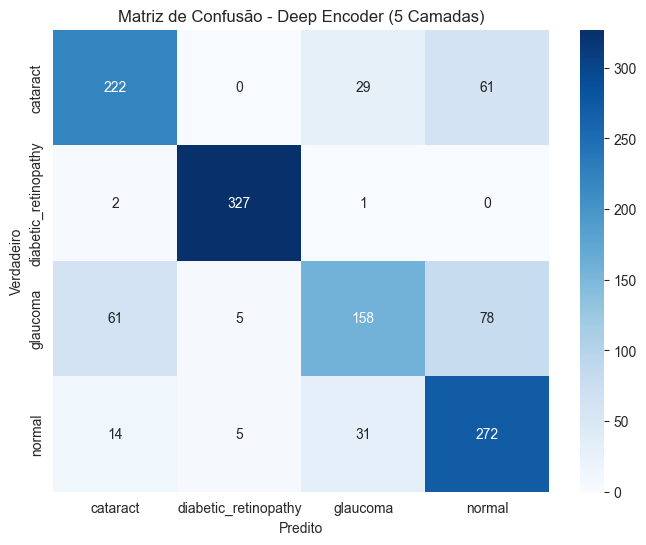

Progresso Geral dos Testes: 100%|██████████| 2/2 [48:41<00:00, 1460.58s/it]



Resumo do Teste Simplificado
Acurácia final com Shallow Encoder (3 Camadas): 72.83%
Acurácia final com Deep Encoder (5 Camadas): 77.33%


In [4]:
# ==============================================================================
# --- 1. CONFIGURAÇÕES E CARREGAMENTO DE DADOS ---
# ==============================================================================
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'datasetsTCC/Doencas-Olhos' # Verifique se este caminho está correto
print(f"Usando dispositivo: {DEVICE}")

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        print(f"Classes encontradas: {self.class_to_idx}")

        # MUDANÇA: Adicionado tqdm para monitorar a descoberta de ficheiros
        for class_name, class_idx in tqdm(self.class_to_idx.items(), desc="A procurar ficheiros de imagem"):
            class_dir = os.path.join(root_dir, class_name)
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                files_in_class = glob.glob(os.path.join(class_dir, '**', ext), recursive=True)
                self.image_files.extend(files_in_class)
                self.labels.extend([class_idx] * len(files_in_class))

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform: image = self.transform(image)
        return image, label

# Divisão Estratificada (70/30)
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform)
dataset_labels = full_dataset.labels
dataset_indices = list(range(len(full_dataset)))
train_indices, test_indices, _, _ = train_test_split(
    dataset_indices, dataset_labels, test_size=0.30, stratify=dataset_labels, random_state=42
)
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"\nDivisão estratificada (70/30) concluída:")
print(f"Conjunto de Treino: {len(train_dataset)} imagens")
print(f"Conjunto de Teste: {len(test_dataset)} imagens")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("\nDataLoaders de treino e teste criados com sucesso!")


# ==============================================================================
# --- 2. DEFINIÇÃO DAS ARQUITETURAS DOS ENCODERS ---
# ==============================================================================
ShallowEncoder = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten()
)

DeepEncoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten()
)

# ==============================================================================
# --- 3. FUNÇÃO PARA EXTRAIR CARACTERÍSTICAS (COM BARRA DE PROGRESSO) ---
# ==============================================================================
def extract_features(encoder, data_loader, device, desc=""):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc=desc):
            images = images.to(device)
            feature_vecs = encoder(images)
            features.append(feature_vecs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

# ==============================================================================
# --- 4. O EXPERIMENTO SIMPLIFICADO COM SVM PADRÃO ---
# ==============================================================================
encoders_to_test = {
    "Shallow Encoder (3 Camadas)": (ShallowEncoder, 'frozen_encoder.pth'),
    "Deep Encoder (5 Camadas)": (DeepEncoder, 'frozen_deep_encoder.pth')
}

results = {}

# MUDANÇA: Adicionado tqdm para monitorar o progresso geral dos testes
for name, (architecture, path) in tqdm(encoders_to_test.items(), desc="Progresso Geral dos Testes"):
    print(f"\n{'='*30}\nIniciando teste para: {name}\n{'='*30}")

    if not os.path.exists(path):
        print(f"ERRO: Arquivo de pesos '{path}' não encontrado. Pulando este teste.")
        continue

    encoder = architecture.to(DEVICE)
    encoder.load_state_dict(torch.load(path))

    X_train, y_train = extract_features(encoder, train_loader, DEVICE, desc=f"Extraindo Treino ({name})")
    X_test, y_test = extract_features(encoder, test_loader, DEVICE, desc=f"Extraindo Teste ({name})")
    print("Extração concluída!")

    # MUDANÇA: verbose=True para imprimir o progresso do treino do SVM
    print("Treinando o modelo SVM Padrão (pode demorar)...")
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, verbose=True)
    svm_classifier.fit(X_train, y_train)

    print("\nAvaliando o modelo no conjunto de teste...")
    y_pred = svm_classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    results[name] = test_accuracy

    print(f"\n--- RESULTADO FINAL PARA {name} ---")
    print(f"Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%")

    print("\nRelatório de Classificação:")
    all_possible_labels = list(full_dataset.class_to_idx.values())
    print(classification_report(y_test, y_pred, labels=all_possible_labels, target_names=full_dataset.class_names, zero_division=0))

    print("Matriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred, labels=all_possible_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# ==============================================================================
# --- 5. COMPARAÇÃO FINAL ---
# ==============================================================================
print(f"\n\n{'='*30}\nResumo do Teste Simplificado\n{'='*30}")
if results:
    for name, acc in results.items():
        print(f"Acurácia final com {name}: {acc * 100:.2f}%")
else:
    print("Nenhum teste foi executado. Verifique se os arquivos .pth existem.")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

# ==============================================================================
# --- 1. CONFIGURAÇÕES E CARREGAMENTO DE DADOS ---
# ==============================================================================
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = 'datasetsTCC/Doencas-Olhos'
print(f"Usando dispositivo: {DEVICE}")

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        print(f"Classes encontradas: {self.class_to_idx}")
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                files_in_class = glob.glob(os.path.join(class_dir, '**', ext), recursive=True)
                self.image_files.extend(files_in_class)
                self.labels.extend([class_idx] * len(files_in_class))

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform: image = self.transform(image)
        return image, label

# --- MUDANÇA: Divisão Estratificada em 70% Treino, 15% Validação, 15% Teste ---
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform)
dataset_labels = full_dataset.labels
dataset_indices = list(range(len(full_dataset)))

# Primeira divisão: 70% treino, 30% para o restante
train_indices, temp_indices, _, temp_labels = train_test_split(
    dataset_indices, dataset_labels, test_size=0.30, stratify=dataset_labels, random_state=42
)
# Segunda divisão: divide o restante em 15% validação e 15% teste
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"\nDivisão estratificada (70/15/15) concluída:")
print(f"Conjunto de Treino: {len(train_dataset)} imagens")
print(f"Conjunto de Validação: {len(val_dataset)} imagens")
print(f"Conjunto de Teste: {len(test_dataset)} imagens")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("\nDataLoaders criados com sucesso!")

# ==============================================================================
# --- 2. DEFINIÇÃO DA ARQUITETURA DO ENCODER PROFUNDO ---
# ==============================================================================
DeepEncoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten()
)

# ==============================================================================
# --- 3. FUNÇÃO PARA EXTRAIR CARACTERÍSTICAS ---
# ==============================================================================
def extract_features(encoder, data_loader, device, desc=""):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc=desc):
            images = images.to(device)
            feature_vecs = encoder(images)
            features.append(feature_vecs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

# ==============================================================================
# --- 4. EXPERIMENTO COM VALIDAÇÃO E TESTE (DEEP ENCODER + SVM) ---
# ==============================================================================
encoder_path = 'frozen_deep_encoder.pth'
print(f"\n{'='*30}\nIniciando teste para: Deep Encoder\n{'='*30}")

if not os.path.exists(encoder_path):
    print(f"ERRO: Arquivo de pesos '{encoder_path}' não encontrado.")
else:
    # 1. Carregar o encoder treinado
    encoder = DeepEncoder.to(DEVICE)
    encoder.load_state_dict(torch.load(encoder_path))

    # 2. Extrair características para todos os conjuntos
    X_train, y_train = extract_features(encoder, train_loader, DEVICE, desc="Extraindo Treino")
    X_val, y_val = extract_features(encoder, val_loader, DEVICE, desc="Extraindo Validação")
    X_test, y_test = extract_features(encoder, test_loader, DEVICE, desc="Extraindo Teste")
    print("Extração de todas as características concluída!")

    # 3. ETAPA DE VALIDAÇÃO: Encontrar os melhores hiperparâmetros
    print("\n--- Iniciando Validação (Busca de Hiperparâmetros) ---")
    best_score = 0
    best_params = {}
    param_grid = {'C': [1, 100], 'gamma': [0.001, 'scale']}

    # Adiciona tqdm para monitorar a busca
    # Linha correta
    search_space = list(product(param_grid['C'], param_grid['gamma']))
    for C, gamma in tqdm(search_space, desc="Validando Hiperparâmetros SVM"):
        svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42)
        svm.fit(X_train, y_train)
        score = svm.score(X_val, y_val)
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}

    print(f"\nMelhores parâmetros encontrados: {best_params} (Acurácia na Validação: {best_score:.4f})")

    # 4. ETAPA DE TREINO FINAL: Treinar o SVM com os melhores parâmetros
    print("\n--- Treinando Modelo Final ---")
    # Opcional, mas recomendado: junte os dados de treino e validação para o treino final
    X_train_full = np.concatenate([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])

    final_svm = SVC(**best_params, kernel='rbf', random_state=42)
    final_svm.fit(X_train_full, y_train_full)
    print("Modelo final treinado com sucesso!")

    # 5. ETAPA DE TESTE FINAL: Avaliar no conjunto de teste
    print("\n--- Avaliando no Conjunto de Teste ---")
    y_pred = final_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"\n--- RESULTADO FINAL PARA DEEP ENCODER ---")
    print(f"Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%")

    print("\nRelatório de Classificação:")
    all_possible_labels = list(full_dataset.class_to_idx.values())
    print(classification_report(y_test, y_pred, labels=all_possible_labels, target_names=full_dataset.class_names, zero_division=0))

    print("Matriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred, labels=all_possible_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão - Deep Encoder')
    plt.show()

Usando dispositivo: cuda
Classes encontradas: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

Divisão estratificada (70/15/15) concluída:
Conjunto de Treino: 2951 imagens
Conjunto de Validação: 633 imagens
Conjunto de Teste: 633 imagens

DataLoaders criados com sucesso!

Iniciando teste para: Deep Encoder


Extraindo Teste: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Extração de todas as características concluída!

--- Iniciando Validação (Busca de Hiperparâmetros) ---


Validando Hiperparâmetros SVM:   0%|          | 0/4 [00:00<?, ?it/s]